In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn import preprocessing

import gradient
import dataset
import computations
import layer
#from layer import Linear, Softmax, Gradient
import network

import datetime
import time

In [2]:
np.random.seed(400)
np.seterr(over='raise');
plt.rcParams['figure.figsize'] = (15.0, 5.0)

In [3]:
network1 = network.Network()
cifar = dataset.CIFAR_IMAGES()
#asgn1.test_batch_images(cifar_batch1)

In [4]:
#### Exercise - 1 ###
# Read in the data & initialize the parameters of the network

filePathLocal_labels = 'Dataset/batches.meta'
filePathLocal_batch = 'Dataset/data_batch_1'
filePathLocal_data_TRAIN = 'Dataset/data_batch_1'
filePathLocal_data_VALIDATION = 'Dataset/data_batch_2'
filePathLocal_data_TEST = 'Dataset/test_batch'

filePathList = (filePathLocal_data_TRAIN, filePathLocal_data_VALIDATION, filePathLocal_data_TEST)

# Read TRAIN, VALIDATION, TEST data into numpy arrays (numpy.ndarray) from local files
network1.ReadData(cifar, filePathList)
# X = (d, N), Y = (K, N), y = (N,)   # N=number of total images in X
# X = (3072, 10000), Y = (10, 10000), y = (10000,)

# Find the MEAN and STD of trainX and broadcast them for matrix calculations
# trainX_Broadcast_MeanStd = (mean_train_X_broadcast, std_train_X_broadcast)
trainX_Broadcast_MeanStd = network1.MeanStd_Train_X(network1.train_X)

# Transform the INPUT to have zero mean ** Check that one if we need to transform all of them separately or
# only having the normalization as in here??
# Normalize all INPUT data by using MEAN and STD of TRAIN DATA
# OR should we normalize each of them using their own MEAN and STD ** selected that one
# NORMALIZE by using TRAINING DATA
train_X_Norm = network1.NormalizeData(network1.train_X, trainX_Broadcast_MeanStd)
#validation_X_Norm = network1.NormalizeData(network1.validation_X, trainX_Broadcast_MeanStd)
# NORMALIZE by using VALIDATION DATA
validation_X_Norm = network1.NormalizeData_Per_DataSet(network1.validation_X)
#test_X_Norm = network1.NormalizeData(network1.test_X, trainX_Broadcast_MeanStd)
# NORMALIZE by using TEST DATA
test_X_Norm = network1.NormalizeData_Per_DataSet(network1.test_X)

# mu = 0; d = network1.train_X.shape[0]; m = 50; K = network1.train_Y.shape[0]
# we will use only 20 of 3072 to have a dimension reduction in comparing grad_analytic and grad_Numerical
mu = 0; d = 20; m = 50; K = network1.train_Y.shape[0]

initial_sizes = (mu, d, m, K)

#sigma1 = 1 / int(np.sqrt(d))
sigma1 = 1 / np.sqrt(d)
sigma2 = 1 / np.sqrt(m)

# Generate W1, W2, b1, b2 matrices with initial values
#(W1, W2, b1, b2) = network1.Initialize_W_b(d, m, K, sigma1, sigma2)
(W1, W2, b1, b2) = network1.Initialize_W_b(initial_sizes, sigma1, sigma2)
# W1 = (m, d),     W2 = (K, m),    b1 = (m, 1),   b2 = (K, 1)
# W1 = (50, 3072), W2 = (10, 50),  b1 = (50, 1),  b2 = (10, 1) # if we use the whole dimensions/features
# W1 = (50, 20),   W2 = (10, 50),  b1 = (50, 1),  b2 = (10, 1) # if we use 20 dimensions/features

In [5]:
'''
print("Mean-STD:\n trainX_Broadcast_MeanStd[0]=\n{}\n\ntrainX_Broadcast_MeanStd[1]=\n{}".\
      format(trainX_Broadcast_MeanStd[0], trainX_Broadcast_MeanStd[1]))
print("\n\nMean-STD:\n train_X_Norm.mean(axis=1)={}\n\n".format(train_X_Norm.mean(axis=1)))
'''
print("Shape check:\n train_X_Norm={}\t validation_X_Norm={}\t test_X_Norm={}".format(train_X_Norm.shape, validation_X_Norm.shape, test_X_Norm.shape))
print(" train_Y={}\t\t validation_Y={}\t\t test_Y={}".format(network1.train_Y.shape, network1.validation_Y.shape, network1.test_Y.shape))
print(" train_y={}\t\t validation_y={}\t\t\t test_y={}".format(network1.train_y.shape, network1.validation_y.shape, network1.test_y.shape))
print(" W1={}\t\t\t W2={}\t\t\t\t b1={}\t\t\t b2={}".format(W1.shape, W2.shape, b1.shape, b2.shape))

Shape check:
 train_X_Norm=(3072, 10000)	 validation_X_Norm=(3072, 10000)	 test_X_Norm=(3072, 10000)
 train_Y=(10, 10000)		 validation_Y=(10, 10000)		 test_Y=(10, 10000)
 train_y=(10000,)		 validation_y=(10000,)			 test_y=(10000,)
 W1=(50, 20)			 W2=(10, 50)				 b1=(50, 1)			 b2=(10, 1)


In [6]:
type(network1.validation_X)

numpy.ndarray

In [7]:
#### Exercise - 2 ###
# Compute the gradients for the network parameters

# only 20 features are used for gradient-TEST calculations and 
# 2 images only not the whole batch (10k images)
# X_batch = train_X_Norm[0:d, :]                 # if we would like to test with the entire batch
# num_image = number of images to use in gradient comparison calculations 
num_image = 2
X_batch = train_X_Norm[0:d, 0:num_image]
Y_batch = network1.train_Y[:, 0:num_image]
y_batch = network1.train_y[0:num_image]

linearLayer1 = layer.Linear()
reluLayer = layer.ReLU()             # not an exact layer but operational step..
linearLayer2 = layer.Linear()
softmaxLayer = layer.Softmax()       # not an exact layer but operational step..

layers = [linearLayer1, reluLayer, linearLayer2, softmaxLayer]

'''
S1 = linearLayer1.Forward(X_batch, W1, b1)
# h = X(layer_no) ... X(0)=represents the input
H = ReLUlayer.Forward(S1)
S = linearLayer1.Forward(H, W2, b2)
P = softmaxLayer.Forward(S)
'''
W = [W1, W2]
b = [b1, b2]

P, H = network1.EvaluationClassifier(layers, X_batch, W, b)


In [8]:
#### Exercise - 2 ###
# let's test the same process with a loop. this time, in the loop, one layer's output will be 
# the input of the following layer
num_image = 2
X_batch = train_X_Norm[0:d, 0:num_image]
Y_batch = network1.train_Y[:, 0:num_image]
y_batch = network1.train_y[0:num_image]

linearLayer1 = layer.Linear()
reluLayer = layer.ReLU()             # not an exact layer but operational step..
linearLayer2 = layer.Linear()
softmaxLayer = layer.Softmax() 

layers = [linearLayer1, reluLayer, linearLayer2, softmaxLayer]

W = [W1, W2]
b = [b1, b2]


P, H = network1.EvaluationClassifier_loop(layers, X_batch, W, b)

In [9]:
def GradientComparison_Analytical_Numerical(X, H, Y, lambda_cost = 0, h = 1e-5):
    grad = gradient.Gradient()
    G = -np.subtract(Y, P) # only for 2 images (change num_image value if you want to use different # of images)
    N = Y_batch.shape[1]
    
    (grad_W2, grad_b2, G) = grad.ComputeGradients_Linear_HiddenLayer(N, G, H, lambda_cost, W2)
    #print('grad_W2.shape={}'.format(grad_W2.shape))
    #print('grad_b2.shape={}'.format(grad_b2.shape))
    
    G = reluLayer.Backward(G, H)
    N = H.shape[1]
    
    (grad_W1, grad_b1) = grad.ComputeGradients_Linear_FirstLayer(N, G, X_batch, lambda_cost, W1)
    
    start_time = datetime.datetime.now()

    W = [W1, W2]
    b = [b1, b2]
    #X_all = [X_batch, H]
    #(grad_W_num, grad_b_num) = grad.ComputeGradsNumSlow(layers, X_batch, Y_batch, W, b, lambda_cost, h=1e-5)
    (grad_W_num, grad_b_num) = grad.ComputeGradsNumSlow(X, Y, W, b, lambda_cost, h)

    grad_W1_num = grad_W_num[0]
    grad_W2_num = grad_W_num[1]

    grad_b1_num = grad_b_num[0]
    grad_b2_num = grad_b_num[1]

    end_time = datetime.datetime.now()

    print("Calculation time of GradsNumSlow: " + str(end_time - start_time))
    
    print('\n\n***** grad_W1, grad_W1_num')
    grad.CompareGradients_W(grad_W1, grad_W1_num)
    
    print('\n\n***** grad_W2, grad_W2_num')
    grad.CompareGradients_W(grad_W2, grad_W2_num)
    
    print('\n\n***** grad_b1, grad_b1_num')
    grad.CompareGradients_b(grad_b1, grad_b1_num)
    
    print('\n\n***** grad_b2, grad_b2_num')
    grad.CompareGradients_b(grad_b2, grad_b2_num)
    

In [10]:
# takes around ?? minutes
GradientComparison_Analytical_Numerical(X_batch, H, Y_batch, lambda_cost = 0, h = 1e-5)

Calculation time of GradsNumSlow: 0:00:00.289948


***** grad_W1, grad_W1_num

grad_W_difference_MEAN = 7.448042807619361e-12
grad_W_difference_MIN = 0.0
grad_W_difference_MAX = 4.180217977323153e-11

grad_W_MIN = 0.0
grad_W_num_MIN = 0.0
grad_W_MAX = 0.263187266439426
grad_W_num_MAX = 0.26318726642493573


***** grad_W2, grad_W2_num

grad_W_difference_MEAN = 7.532225861799947e-12
grad_W_difference_MIN = 0.0
grad_W_difference_MAX = 4.598055269866563e-11

grad_W_MIN = 0.0
grad_W_num_MIN = 0.0
grad_W_MAX = 0.6481946016209915
grad_W_num_MAX = 0.648194601637897


***** grad_b1, grad_b1_num

grad_b_difference_MEAN = 8.697536371671256e-12
grad_b_difference_MIN = 0.0
grad_b_difference_MAX = 2.8872293444948127e-11

grad_b_MIN = 0.0
grad_b_num_MIN = [0.]

grad_b_MAX = 0.2321359378763498
grad_b_num_MAX = [0.23213594]


***** grad_b2, grad_b2_num

grad_b_difference_MEAN = 1.3584279534573085e-11
grad_b_difference_MIN = 1.8527263057066534e-12
grad_b_difference_MAX = 3.675354465215719e-11

grad_b_MI

In [11]:
def GradientSanityCheck(network1, train_X_Norm):
    n_epocs = 200    # number of times we will iterate on the entire data (10K images in our case)
    batch_size = 100    # the size of the mini-batch. in other words, number of images in 1 mini-batch.
    eta = 0.001      # learning rate (step-size)
    lambda_cost = 0  # regularization coefficient (punishment)
    #d = train_X_Norm.shape[0]
    d = 3072
    m = 50           # number of nodes in the hidden layer
    K = network1.train_Y.shape[0]  # number of classes

    # Generate W1, W2, b1, b2 matrices with initial values
    # (W1, W2, b1, b2) = network1.Initialize_W_b(d, m, K)
    sigma1 = 1 / int(np.sqrt(d))
    sigma2 = 1 / np.sqrt(m)
    #(W1, W2, b1, b2) = network1.Initialize_W_b(d, m, K, sigma1, sigma2)
    initial_sizes = [0, d, m, K]
    (W1, W2, b1, b2) = network1.Initialize_W_b(initial_sizes, sigma1, sigma2)

    W = [W1, W2]
    b = [b1, b2]

    J_epocs_train = np.zeros(n_epocs)         # cost array     - will keep costs per epoc (iteration)
    Accuracy_epocs_train = np.zeros(n_epocs)  # accuracy array - will keep accuracy per epoc (iteration)

    linearLayer1 = layer.Linear()
    reluLayer = layer.ReLU()             # not an exact layer but operational step..
    linearLayer2 = layer.Linear()
    softmaxLayer = layer.Softmax()       # not an exact layer but operational step..
    ReLUlayer = layer.ReLU()
    grad = gradient.Gradient()

    layers = [linearLayer1, reluLayer, linearLayer2, softmaxLayer]
    # total_batch = how many mini-batches will we need to cover the entire training set?
    #total_batch = int(train_X_normalized.shape[1] / batch_size)
    #n_sanity_batch = 1
    # we will only use 100 images for sanity check that means there will be only 1 mini-batch
    n_sanity_batch = 1
    n_test_images = batch_size * n_sanity_batch

    start_time = datetime.datetime.now()
    for e in range(n_epocs):
        for batch in range(n_sanity_batch):
            index_list = list(range(batch * batch_size, (batch + 1) * batch_size))
            # shuffling is not necessary but good to have
            #np.random.shuffle(index_list)
            #X_batch = train_X_Norm[:, index_list]
            X_batch = train_X_Norm[0:d, index_list]
            Y_batch = network1.train_Y[:, index_list]

            P, H = network1.EvaluationClassifier(layers, X_batch, W, b)

            G2 = -np.subtract(network1.train_Y[:, index_list], P)
            N2 = Y_batch.shape[1] #N

            # N, G
            (grad_W2, grad_b2, G1) = grad.ComputeGradients_Linear_HiddenLayer(N2, G2, H, lambda_cost, W2) 
            G0 = reluLayer.Backward(G1, H)
            N1 = H.shape[1] #N
            # N, G
            (grad_W1, grad_b1) = grad.ComputeGradients_Linear_FirstLayer(N1, G0, X_batch, lambda_cost, W1)

            W1 = W1 - eta * grad_W1
            W2 = W2 - eta * grad_W2

            #W1 = Wstar1
            #W2 = Wstar2

            bstar_m1 = b1 - eta * grad_b1
            b1 = bstar_m1[:, :1]
            #b1 = bstar1

            bstar_m2 = b2 - eta * grad_b2
            b2 = bstar_m2[:, :1]
            #b2 = bstar2

        W = [W1, W2]
        b = [b1, b2]

        #J_train = network1.Cost(X_batch, Y_batch, W, b, lambda_cost)
        #J_train = network1.Cost(train_X_Norm[:, 0:], Y_batch, W, b, lambda_cost)
        #J_train = network1.Cost(train_X_Norm[:, :batch*total_batch], network1.train_y[index_list],\
         #                       W, b, lambda_cost)
        J_train = network1.Cost(train_X_Norm[0:d, 0:n_test_images], network1.train_Y[:, 0:n_test_images],\
                                W, b, lambda_cost)

        J_epocs_train[e] = J_train

        #P_train = self.EvaluationClassifier(train_X_normalized, W, b)
        #k_train = np.argmax(P, axis=0)

        P, H = network1.EvaluationClassifier(layers, train_X_Norm[0:d, 0:n_test_images], W, b)
        k_train = np.argmax(P, axis=0)

        A_train = network1.ComputeAccuracy(k_train, network1.train_y[0:n_test_images])
        Accuracy_epocs_train[e] = A_train

        #self.Plot_Train_Validation_Cost_Accurracy(J_epocs_train, Accuracy_epocs_train)

    end_time = datetime.datetime.now()
    
    print("Calculation time of GradientSanityCheck: " + str(end_time - start_time))
    ## d = 20,   N=100    >>> Cost from 2.54  to 2.38    >>> Accuracy from 0.08 to 0.15    >> time: 0.15 seconds
    ## d = 3072, N=100    >>> Cost from 2.439 to 1.199   >>> Accuracy from 0.15 to 0.74    >> time: 1.23 seconds
    ## d = 3072, N=10000  >>> Cost from 2.347 to 1.323   >>> Accuracy from 0.1906 to 0.543 >> time: 3.08 minutes
        
    print(J_epocs_train)
    print(Accuracy_epocs_train)

In [12]:
# takes 2 seconds
GradientSanityCheck(network1, train_X_Norm)

Calculation time of GradientSanityCheck: 0:00:01.190475
[2.38141841 2.36450693 2.34802706 2.33194751 2.31618708 2.30089071
 2.28588608 2.27091724 2.25622107 2.24157926 2.22699612 2.2126453
 2.19846949 2.18458225 2.17115511 2.15809151 2.14531877 2.13276476
 2.12052738 2.10864204 2.09704919 2.08555144 2.07424372 2.06321992
 2.05218869 2.04139736 2.03080174 2.0204127  2.01013614 2.00001399
 1.99006018 1.98020556 1.97045738 1.9608275  1.95132739 1.94191467
 1.93270478 1.92361452 1.91469319 1.90590944 1.89718644 1.88857539
 1.88003341 1.87158506 1.86323861 1.85496985 1.84682741 1.83875007
 1.83076322 1.82286238 1.81504002 1.80733752 1.79967122 1.79208482
 1.78451646 1.77705237 1.76962499 1.76226563 1.75497114 1.74765122
 1.74041076 1.73319945 1.72608571 1.71903342 1.71205125 1.70508384
 1.69808495 1.69118195 1.68434652 1.67760025 1.6709648  1.66440851
 1.6578919  1.65145517 1.64509149 1.63876215 1.63247444 1.62626872
 1.62017265 1.61407749 1.60807326 1.60208982 1.59617654 1.59030353
 1.5845

In [13]:
def Vanilla_MiniBacth_GD(network1, train_X_Norm):
    # GradientSanityCheck_FullTraining(network1, train_X_Norm)
    # This one is called "Vanilla mini-batch gradient descent"
    n_epocs = 200    # number of times we will iterate on the entire data (10K images in our case)
    batch_size = 100    # the size of a mini-batch. in other words, number of images in 1 mini-batch.
    eta = 0.001      # learning rate (step-size)
    #eta = 0.001     # MEL: If I use an eta bigger than 1e-3, I receive an overflow error for SOFTMAX
    lambda_cost = 0  # regularization coefficient (punishment)
    #lambda_cost = 0.01
    d = train_X_Norm.shape[0]
    m = 50 
    K = network1.train_Y.shape[0]  # number of classes

    # Generate W1, W2, b1, b2 matrices with initial values
    # (W1, W2, b1, b2) = network1.Initialize_W_b(d, m, K)
    sigma1 = 1 / int(np.sqrt(d))
    sigma2 = 1 / np.sqrt(m)
    #(W1, W2, b1, b2) = network1.Initialize_W_b(d, m, K, sigma1, sigma2)
    initial_sizes = [0, d, m, K]
    (W1, W2, b1, b2) = network1.Initialize_W_b(initial_sizes, sigma1, sigma2)

    W = [W1, W2]
    b = [b1, b2]

    J_epocs_train = np.zeros(n_epocs)         # cost array     - will keep costs per epoc (iteration)
    Accuracy_epocs_train = np.zeros(n_epocs)  # accuracy array - will keep accuracy per epoc (iteration)

    linearLayer1 = layer.Linear()
    reluLayer = layer.ReLU()             # not an exact layer but operational step..
    linearLayer2 = layer.Linear()
    softmaxLayer = layer.Softmax()       # not an exact layer but operational step..
    ReLUlayer = layer.ReLU()
    grad = gradient.Gradient()

    layers = [linearLayer1, reluLayer, linearLayer2, softmaxLayer]
    # total_batch = how many mini-batches will we need to cover the entire training set?
    total_batch = int(train_X_Norm.shape[1] / batch_size)
    #n_sanity_batch = 1
    # we will only use 100 images for sanity check that means there will be only 1 mini-batch
    #n_sanity_batch = 1
    #n_test_images = batch_size * n_sanity_batch

    start_time = datetime.datetime.now()
    for e in range(n_epocs):
        for batch in range(total_batch):
            index_list = list(range(batch * batch_size, (batch + 1) * batch_size))
            # shuffling is not necessary but good to have
            #np.random.shuffle(index_list)
            #X_batch = train_X_Norm[:, index_list]
            X_batch = train_X_Norm[:, index_list]
            Y_batch = network1.train_Y[:, index_list]

            P, H = network1.EvaluationClassifier(layers, X_batch, W, b)

            G2 = -np.subtract(network1.train_Y[:, index_list], P)  # G
            N2 = Y_batch.shape[1] #N

            # N, G
            (grad_W2, grad_b2, G1) = grad.ComputeGradients_Linear_HiddenLayer(N2, G2, H, lambda_cost, W2) 
            G0 = reluLayer.Backward(G1, H)
            N1 = H.shape[1] #N
            # N, G
            (grad_W1, grad_b1) = grad.ComputeGradients_Linear_FirstLayer(N1, G0, X_batch, lambda_cost, W1)

            # W1star, W2star
            W1 = W1 - eta * grad_W1
            W2 = W2 - eta * grad_W2

            # b1star, b2star
            bstar_m1 = b1 - eta * grad_b1
            b1 = bstar_m1[:, :1]  # there's a broadcast issue needs to be fixed, that's why we pick only 1 column

            bstar_m2 = b2 - eta * grad_b2
            b2 = bstar_m2[:, :1]  # broadcast issue, this is a quick workaround - use 1 column

        W = [W1, W2]
        b = [b1, b2]

        J_train = network1.Cost(train_X_Norm, network1.train_Y, W, b, lambda_cost)

        J_epocs_train[e] = J_train

        P, H = network1.EvaluationClassifier(layers, train_X_Norm, W, b)
        k_train = np.argmax(P, axis=0)

        A_train = network1.ComputeAccuracy(k_train, network1.train_y)
        Accuracy_epocs_train[e] = A_train

        #self.Plot_Train_Validation_Cost_Accurracy(J_epocs_train, Accuracy_epocs_train)

    end_time = datetime.datetime.now()
    
    print("Calculation time of GradientSanityCheck: " + str(end_time - start_time))
        
    print(J_epocs_train)
    print(Accuracy_epocs_train)

In [14]:
#GradientSanityCheck_FullTraining(network1, train_X_Norm)
# takes around 3-3.5 minutes
Vanilla_MiniBacth_GD(network1, train_X_Norm)

Calculation time of GradientSanityCheck: 0:03:08.302447
[2.22799015 2.27064244 2.4520189  3.14684817 2.60470707 2.40477466
 2.16056023 2.11753492 2.15546103 2.21632305 2.13731107 2.04741237
 1.93581681 1.86861164 1.82401917 1.81911749 1.79649215 1.76987219
 1.75516484 1.74479231 1.7532359  1.76821934 1.76079228 1.72981642
 1.70511877 1.69049981 1.68224735 1.6796235  1.67076782 1.66707202
 1.65842817 1.65348078 1.64515917 1.63966521 1.63320274 1.62901528
 1.62523961 1.62268987 1.62187167 1.62013767 1.62130716 1.62033927
 1.617709   1.6124351  1.60391631 1.59500496 1.58477652 1.57682676
 1.56834903 1.56267671 1.55585043 1.55172019 1.54641864 1.54351545
 1.53966646 1.5392158  1.53870426 1.54062236 1.54395728 1.54485049
 1.54871393 1.54264392 1.53819469 1.53021933 1.52306363 1.51802995
 1.51288988 1.51011819 1.50489087 1.50306641 1.49840728 1.49735075
 1.49259763 1.49129901 1.48688049 1.48434576 1.47969212 1.47578124
 1.47163702 1.46748457 1.46403305 1.45959272 1.45681042 1.4526378
 1.4508

In [15]:
#def Plot_Train_Validation_Cost_Accurracy(self, Cost_Train, Cost_Validation, Acc_Train, Acc_Validation):
def Plot_Train_Validation_Cost_Accurracy(Cost_Train, Cost_Validation, Acc_Train, Acc_Validation, Eta):
        plt.subplot(1,3,1)
        plt.plot(Cost_Train, 'g-', label='Train')
        plt.plot(Cost_Validation, 'r-', label='Validation')
        plt.title('Cost Comparison')
        plt.xlabel('n_records')
        plt.ylabel('Cost')
        plt.legend()
        plt.grid('on')
        
        plt.subplot(1,3,2)
        plt.plot(Acc_Train, 'g-', label='Train')
        plt.plot(Acc_Validation, 'r-', label='Validation')
        plt.title('Accuracy Comparison')
        plt.xlabel('n_records')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid('on')
        
        plt.subplot(1,3,3)
        plt.plot(Eta, 'g-', label='Eta')
        plt.title('Eta Change')
        plt.xlabel('Time')
        plt.ylabel('Eta')
        plt.legend()
        plt.grid('on')

In [16]:
# this function uses the FULL training data to calculate the ACCURACY & COST
def Train_Cyclical(param_list, cost_calculation_method = 'Batch_aggregated'):
    # param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, 
    #               record_per_cycle, m, eta_min, eta_max, n_steps]
    '''
    Up until now, we have trained our networks with Vanilla mini-batch gradient descent. 
    To help speed up training times and avoid time-consuming searches for good values of eta, we will now
    implement mini-batch-GD training where the learning rate at each update step is defined in a cylical way
    check equations (14) and (15) in the assignment.
    '''
    network1 = param_list[0]
    train_X_Norm = param_list[1]        # 45.000 images
    validation_X_Norm = param_list[2]   # 5.000 images
    # the size of a mini-batch. in other words, number of images in 1 mini-batch
    batch_size = param_list[3]          # 100
    # number of triangles that you want to use to test different eta values
    n_cycles = param_list[4]            # 1
    # regularization coefficient (punishment)
    lambda_cost = param_list[5]         # 0.01
    # how many calculations do you want to see per cycle? = 10? 20? 30? to plot the graph
    # record_per_cycle = 100  (+1 is to show the first calculation, as well)
    record_per_cycle = param_list[6]
 
    d = train_X_Norm.shape[0]           # dimension of X_train... 3072 = 32 x 32 x 3
    m = param_list[7]                   # number of nodes in the hidden layer... 50
    K = network1.train_Y.shape[0]       # number of classes... 10
    eta_min = param_list[8]             # learning rate (step-size)   i.e. 1e-5 
    eta_max = param_list[9]             # learning rate (step-size)   i.e. 1e-1 
    # n_s = k * np.floor(n/n_batch) by definition in the assignment
    # so, k corresponds to the number of epochs to complete a half cycle, for a full-cycle,
    # we need to run the calculations 2*k times. i.e. if k=5, we need 10 epochs
    n_steps = param_list[10]            # number of steps to complete a half cycle(triangle)

    # Generate W1, W2, b1, b2 matrices with initial values
    # (W1, W2, b1, b2) = network1.Initialize_W_b(d, m, K)
    sigma1 = 1 / int(np.sqrt(d))
    sigma2 = 1 / np.sqrt(m)
    #(W1, W2, b1, b2) = network1.Initialize_W_b(d, m, K, sigma1, sigma2)
    initial_sizes = [0, d, m, K]
    (W1, W2, b1, b2) = network1.Initialize_W_b(initial_sizes, sigma1, sigma2)

    W = [W1, W2]
    b = [b1, b2]

    linearLayer1 = layer.Linear()
    reluLayer = layer.ReLU()             # not an exact layer but operational step..
    linearLayer2 = layer.Linear()
    softmaxLayer = layer.Softmax()       # not an exact layer but operational step..
    ReLUlayer = layer.ReLU()
    grad = gradient.Gradient()

    layers = [linearLayer1, reluLayer, linearLayer2, softmaxLayer]
    # total_batch = how many mini-batches will we need to cover the entire training set?
    total_batch = int(np.floor(train_X_Norm.shape[1] / batch_size))
    
    # A full cycle once go up (from eta_min to eta_max) and once go down (from eta_max to eta_min)
    # so we multiply by 2
    #n_cycles = 1   # corresponds to "L array" in 2.L.ns in the assignment .. 
    # L=the current cycle number ... n_cycles=the total number of cycles to be applied
    # so L is an element of n_cycle >> i.e. L = {0, 1, 2, 3} if n_cycles = 4 
    # n_epocs=10 for 1 full cycle having n_steps=500 and batch_size=100
    # n_s = k * np.floor(n/n_batch) by definition in the assignment.. see the previous explanation above for n_steps
    n_epochs = int(2 * n_cycles * (n_steps / total_batch))
    #n_sanity_batch = 1
    # we will only use 100 images for sanity check that means there will be only 1 mini-batch
    #n_sanity_batch = 1
    #n_test_images = batch_size * n_sanity_batch
     
    n_records = total_batch * n_epochs         # number of batches will be used IN TOTAL for ALL calculations
    # i.e. 450 * 4 = 1800
    
    # how many points in total we will have in the COST graph
    cost_record = record_per_cycle * n_cycles + 1  # 100 * 1 + 1 = 101
    ###comparison_number = total_batch/cost_record  
    # to be able to have that many points, at which batch we should run the COST functions (e.g. in every 18 batch)
    comparison_number = int(n_records / (cost_record - 1))  # 1800/100 = 18
    
    eta_train = np.zeros(n_records)              # we will check if we properly make a triangle
    
    J_epocs_train = np.zeros(cost_record)        # cost array to plot and see how cost changes
    Accuracy_epocs_train = np.zeros(cost_record) # accuracy array
    J_epocs_validation = np.zeros(cost_record) 
    Accuracy_epocs_validation = np.zeros(cost_record)
    
    
    print('batch_size: {}, lambda_cost : {}, d: {}, m: {}, K: {}'.format(batch_size, lambda_cost, d, m, K))
    #print('\ntotal_batch: {}, n_steps : {}, n_epochs: {}, n_records: {}, cost_record: {}'.format(total_batch, n_steps, n_epochs, n_records, cost_record))
    print('\ntotal_batch: {}, n_steps : {}, n_epochs: {}, n_records: {}'.format(total_batch, n_steps, n_epochs, 
                                                                                n_records))
    print('\nrecord_per_cycle: {}, cost_record : {}, comparison_number: {}'.format(record_per_cycle, cost_record, 
                                                                                   comparison_number))
  
    # cycleID in use.. if n_cycles=0 then cycle max will be 0. else it will be incremented by 1 at each 2*n_steps
    cycle_no = 0
    J_train_sum = 0
    n_records = 0       # this will basically show the number of batches processed until now
    list_params = []
    smooth_cost = 0
    cost_record = 0
    # step number in the current cycle, it resets with a new cycle. 
    cycle_step = 0   # just to see where we are in the current triangle
    
    start_time = datetime.datetime.now()
    for e in range(n_epochs):
        for batch in range(total_batch):
            index_list = list(range(batch * batch_size, (batch + 1) * batch_size))
            # shuffling is not necessary but good to have
            np.random.shuffle(index_list)
            X_batch = train_X_Norm[:, index_list]
            Y_batch = network1.train_Y[:, index_list]

            P, H = network1.EvaluationClassifier(layers, X_batch, W, b)

            G2 = -np.subtract(network1.train_Y[:, index_list], P)
            N2 = Y_batch.shape[1]

            (grad_W2, grad_b2, G1) = grad.ComputeGradients_Linear_HiddenLayer(N2, G2, H, lambda_cost, W2) 
            G0 = reluLayer.Backward(G1, H)
            N1 = H.shape[1]

            (grad_W1, grad_b1) = grad.ComputeGradients_Linear_FirstLayer(N1, G0, X_batch, lambda_cost, W1)
            
            # n_cycles = 1   # corresponds to "L array" in 2.L.ns in the assignment .. 
            # L=the current cycle number ... n_cycles=the total number of cycles to be applied
            # so L is an element of n_cycle >> i.e. L = {0, 1, 2, 3} if n_cycles = 4 
            #if 2*cycle_no*n_steps <= t and t <= (2*cycle_no+1)*n_steps:
            # n_records corresponds to t in the formula
            if 2*cycle_no*n_steps <= n_records and n_records <= (2*cycle_no+1)*n_steps:
                #eta = eta_min + (t - 2*cycle_no*n_steps)/n_steps*(eta_max-eta_min)
                eta = eta_min + (n_records - 2*cycle_no*n_steps)/n_steps*(eta_max-eta_min)
            #elif (2*cycle_no+1)*n_steps <= t and t <= 2*(cycle_no+1)*n_steps:
            elif (2*cycle_no+1)*n_steps <= n_records and n_records <= 2*(cycle_no+1)*n_steps:
                #eta = eta_max - (t - (2*cycle_no+1)*n_steps)/n_steps*(eta_max-eta_min)
                eta = eta_max - (n_records - (2*cycle_no+1)*n_steps)/n_steps*(eta_max-eta_min)
            
            eta_train[n_records] = eta
            
            # W1star, W2star
            W1 = W1 - eta * grad_W1
            W2 = W2 - eta * grad_W2

            # b1star, b2star
            bstar_m1 = b1 - eta * grad_b1
            b1 = bstar_m1[:, :1]  # there's a broadcast issue needs to be fixed, that's why we pick only 1 column

            bstar_m2 = b2 - eta * grad_b2
            b2 = bstar_m2[:, :1]  # broadcast issue, this is a quick workaround - use 1 column
            
            W = [W1, W2]
            b = [b1, b2]

            #if n_records % 10 == 0:
            if n_records == 0 or (n_records + 1) % comparison_number == 0:
                print('\nepoch: {}, batch: {}, n_records: {}, cycle_step: {}'.format(e, batch, n_records, cycle_step))

                if cost_calculation_method == 'ALL_Data':
                    J_train = network1.Cost(train_X_Norm, network1.train_Y, W, b, lambda_cost)
                    J_epocs_train[cost_record] = J_train

                    P, H = network1.EvaluationClassifier(layers, train_X_Norm, W, b)
                    k_train = np.argmax(P, axis=0)
                    A_train = network1.ComputeAccuracy(k_train, network1.train_y)
                    Accuracy_epocs_train[cost_record] = A_train           

                    J_validation = network1.Cost(validation_X_Norm , network1.validation_Y, W, b, lambda_cost)
                    J_epocs_validation[cost_record] = J_validation

                    P_val, H_val = network1.EvaluationClassifier(layers, validation_X_Norm, W, b)
                    k_validation = np.argmax(P_val, axis=0)
                    A_validation = network1.ComputeAccuracy(k_validation, network1.validation_y)
                    Accuracy_epocs_validation[cost_record] = A_validation
                    
                elif cost_calculation_method == 'Batch_aggregated':
                    J_train = network1.Cost(X_batch, Y_batch, W, b, lambda_cost)
                    J_train_sum += J_train
                    smooth_cost = J_train_sum/(cost_record + 1)
                    #J_epocs_train[n_records] = J_train
                    J_epocs_train[cost_record] = smooth_cost

                    ## If we use the ALL TRAINING data to calculate the training accuracy:
                    # it feels like better to use that one
                    P, H = network1.EvaluationClassifier(layers, train_X_Norm, W, b)
                    k_train = np.argmax(P, axis=0)
                    A_train = network1.ComputeAccuracy(k_train, network1.train_y)
                    Accuracy_epocs_train[cost_record] = A_train

                    J_validation = network1.Cost(validation_X_Norm , network1.validation_Y, W, b, lambda_cost)
                    J_epocs_validation[cost_record] = J_validation

                    P_val, H_val = network1.EvaluationClassifier(layers, validation_X_Norm, W, b)
                    k_validation = np.argmax(P_val, axis=0)
                    A_validation = network1.ComputeAccuracy(k_validation, network1.validation_y)
                    Accuracy_epocs_validation[cost_record] = A_validation
                    
                elif cost_calculation_method == 'Batch_aggregated_ratio':
                    J_train = network1.Cost(X_batch, Y_batch, W, b, lambda_cost)
                    if n_records == 0:
                        smooth_cost = J_train
                    else:
                        #smooth_cost = 0.999*smooth_cost + 0.001 * J_train
                        smooth_cost = 0.99*smooth_cost + 0.01 * J_train
                    #J_epocs_train[n_records] = J_train
                    J_epocs_train[cost_record] = smooth_cost

                    ## If we use the ALL TRAINING data to calculate the training accuracy:
                    # it feels like better to use that one
                    P, H = network1.EvaluationClassifier(layers, train_X_Norm, W, b)
                    k_train = np.argmax(P, axis=0)
                    A_train = network1.ComputeAccuracy(k_train, network1.train_y)
                    Accuracy_epocs_train[cost_record] = A_train

                    J_validation = network1.Cost(validation_X_Norm , network1.validation_Y, W, b, lambda_cost)
                    J_epocs_validation[cost_record] = J_validation

                    P_val, H_val = network1.EvaluationClassifier(layers, validation_X_Norm, W, b)
                    k_validation = np.argmax(P_val, axis=0)
                    A_validation = network1.ComputeAccuracy(k_validation, network1.validation_y)
                    Accuracy_epocs_validation[cost_record] = A_validation
                    
                cost_record += 1        
                
                print('cycle_no: {} ... eta: {} ... time: {}'.format(cycle_no, eta, datetime.datetime.now()))
                print('J_train: {} ... smooth_cost : {} ... J_validation: {}'.format(J_train, smooth_cost, J_validation))

            
            n_records += 1
            cycle_step += 1
            
            if n_records % (2 * n_steps) == 0:
                cycle_no += 1
                cycle_step = 0

    end_time = datetime.datetime.now()
    
    print("Calculation time of Train_Cyclical: " + str(end_time - start_time))
    print("x-axis (steps) must be multiplied by 10 since the values recorded once in every 10 Cycle")
    
    Plot_Train_Validation_Cost_Accurracy(J_epocs_train, J_epocs_validation, Accuracy_epocs_train, 
                                         Accuracy_epocs_validation, eta_train)
    print('batch_size: {}, lambda_cost : {}, d: {}, m: {}, K: {}'.format(batch_size, lambda_cost, d, m, K))
    #print('\ntotal_batch: {}, n_steps : {}, n_epochs: {}, n_records: {}, cost_record: {}'.format(total_batch, n_steps, n_epochs, n_records, cost_record))
    print('\ntotal_batch: {}, n_steps : {}, n_epochs: {}, n_records: {}'.format(total_batch, n_steps, 
                                                                                n_epochs, n_records))
    print('\nrecord_per_cycle: {}, cost_record : {}, comparison_number: {}'.format(record_per_cycle, 
                                                                                   cost_record, comparison_number))
    return layers, W, b, eta_train
    
    

batch_size: 100, lambda_cost : 0.01, d: 3072, m: 50, K: 10

total_batch: 100, n_steps : 500, n_epochs: 10, n_records: 1000

record_per_cycle: 100, cost_record : 101, comparison_number: 10

epoch: 0, batch: 0, n_records: 0, cycle_step: 0
cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-19 22:25:01.139326
J_train: 3.179609418234089 ... smooth_cost : 0 ... J_validation: 3.1863988321416974

epoch: 0, batch: 9, n_records: 9, cycle_step: 9
cycle_no: 0 ... eta: 0.00180982 ... time: 2020-08-19 22:25:02.733370
J_train: 3.0964915630274197 ... smooth_cost : 0 ... J_validation: 3.106709653939336

epoch: 0, batch: 19, n_records: 19, cycle_step: 19
cycle_no: 0 ... eta: 0.00380962 ... time: 2020-08-19 22:25:04.277915
J_train: 2.947296678950883 ... smooth_cost : 0 ... J_validation: 2.962268844930822

epoch: 0, batch: 29, n_records: 29, cycle_step: 29
cycle_no: 0 ... eta: 0.00580942 ... time: 2020-08-19 22:25:05.829267
J_train: 2.8085758128493126 ... smooth_cost : 0 ... J_validation: 2.8319437996408787

ep

cycle_no: 0 ... eta: 0.07580242000000001 ... time: 2020-08-19 22:26:00.483287
J_train: 1.9933939462977608 ... smooth_cost : 0 ... J_validation: 2.2133928917420573

epoch: 3, batch: 89, n_records: 389, cycle_step: 389
cycle_no: 0 ... eta: 0.07780222 ... time: 2020-08-19 22:26:02.074310
J_train: 1.90059816436302 ... smooth_cost : 0 ... J_validation: 2.1094590373004656

epoch: 3, batch: 99, n_records: 399, cycle_step: 399
cycle_no: 0 ... eta: 0.07980202 ... time: 2020-08-19 22:26:03.657134
J_train: 1.9236226479144773 ... smooth_cost : 0 ... J_validation: 2.1566896835254594

epoch: 4, batch: 9, n_records: 409, cycle_step: 409
cycle_no: 0 ... eta: 0.08180182 ... time: 2020-08-19 22:26:05.236729
J_train: 1.8762791876960587 ... smooth_cost : 0 ... J_validation: 2.1043732417456793

epoch: 4, batch: 19, n_records: 419, cycle_step: 419
cycle_no: 0 ... eta: 0.08380162000000001 ... time: 2020-08-19 22:26:06.812773
J_train: 1.967250286500679 ... smooth_cost : 0 ... J_validation: 2.189835415885485



cycle_no: 0 ... eta: 0.044205579999999994 ... time: 2020-08-19 22:27:03.973688
J_train: 1.535902266757951 ... smooth_cost : 0 ... J_validation: 1.8742366967561543

epoch: 7, batch: 89, n_records: 789, cycle_step: 789
cycle_no: 0 ... eta: 0.042205780000000005 ... time: 2020-08-19 22:27:05.552518
J_train: 1.5349341024055985 ... smooth_cost : 0 ... J_validation: 1.8698256980785228

epoch: 7, batch: 99, n_records: 799, cycle_step: 799
cycle_no: 0 ... eta: 0.04020598 ... time: 2020-08-19 22:27:07.125582
J_train: 1.5613984199993072 ... smooth_cost : 0 ... J_validation: 1.9090125774140396

epoch: 8, batch: 9, n_records: 809, cycle_step: 809
cycle_no: 0 ... eta: 0.03820618 ... time: 2020-08-19 22:27:08.697836
J_train: 1.526834375765349 ... smooth_cost : 0 ... J_validation: 1.8718824347310243

epoch: 8, batch: 19, n_records: 819, cycle_step: 819
cycle_no: 0 ... eta: 0.036206379999999996 ... time: 2020-08-19 22:27:10.277120
J_train: 1.546656537014177 ... smooth_cost : 0 ... J_validation: 1.89098

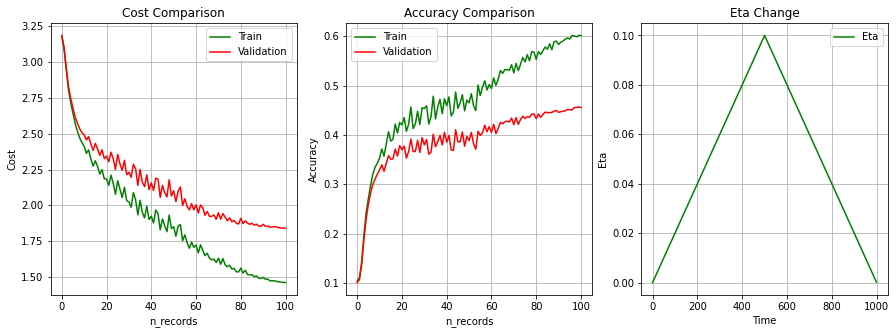

In [17]:
#### Exercise - 3 ###
# takes around 2.5 minutes
# TRAIN = VALIDATION = TEST = 10.000
# Train_Cyclical(network1, train_X_Norm, validation_X_Norm, n_cycles, n_steps)
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max, n_steps]
param_list = [network1, train_X_Norm, validation_X_Norm, 100, 1, 0.01, 100, 50, 1e-5, 1e-1, 500]
layers1, W1, b1, eta_train = Train_Cyclical(param_list, 'ALL_Data')


In [18]:
P_test, H_test = network1.EvaluationClassifier(layers1, test_X_Norm, W1, b1)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.454


In [19]:
print('Eta_Train\nmin: {}\tmax: {}\tmean: {}\tmedian: {}\nstd: {}\tvar: {}'.format(min(eta_train), 
        max(eta_train), np.mean(eta_train), np.median(eta_train), np.std(eta_train), np.var(eta_train)))

Eta_Train
min: 1e-05	max: 0.1	mean: 0.050004999999999994	median: 0.05000500000000001
std: 0.02886474216641126	var: 0.0008331733403334001


batch_size: 100, lambda_cost : 0.01, d: 3072, m: 50, K: 10

total_batch: 100, n_steps : 500, n_epochs: 10, n_records: 1000

record_per_cycle: 100, cost_record : 101, comparison_number: 10

epoch: 0, batch: 0, n_records: 0, cycle_step: 0
cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-19 22:31:52.843279
J_train: 3.0557551089316775 ... smooth_cost : 3.0557551089316775 ... J_validation: 3.1297081393709965

epoch: 0, batch: 9, n_records: 9, cycle_step: 9
cycle_no: 0 ... eta: 0.00180982 ... time: 2020-08-19 22:31:53.732355
J_train: 2.953260775170068 ... smooth_cost : 3.0045079420508727 ... J_validation: 3.0588205187824404

epoch: 0, batch: 19, n_records: 19, cycle_step: 19
cycle_no: 0 ... eta: 0.00380962 ... time: 2020-08-19 22:31:54.574663
J_train: 2.885028398796223 ... smooth_cost : 2.9646814276326565 ... J_validation: 2.92103980168866

epoch: 0, batch: 29, n_records: 29, cycle_step: 29
cycle_no: 0 ... eta: 0.00580942 ... time: 2020-08-19 22:31:55.391162
J_train: 2.763397556953467 ... smooth

cycle_no: 0 ... eta: 0.06980302 ... time: 2020-08-19 22:32:21.453044
J_train: 1.6876416278863904 ... smooth_cost : 2.1071128574730413 ... J_validation: 2.181953233936328

epoch: 3, batch: 59, n_records: 359, cycle_step: 359
cycle_no: 0 ... eta: 0.07180282 ... time: 2020-08-19 22:32:22.270812
J_train: 1.5118728940330464 ... smooth_cost : 2.091025290893582 ... J_validation: 2.1415231442094362

epoch: 3, batch: 69, n_records: 369, cycle_step: 369
cycle_no: 0 ... eta: 0.07380262 ... time: 2020-08-19 22:32:23.086777
J_train: 1.5538177532004251 ... smooth_cost : 2.0768882504279724 ... J_validation: 2.1136091187898085

epoch: 3, batch: 79, n_records: 379, cycle_step: 379
cycle_no: 0 ... eta: 0.07580242000000001 ... time: 2020-08-19 22:32:23.892398
J_train: 1.6379831175400594 ... smooth_cost : 2.0656342726616157 ... J_validation: 2.2040511018222455

epoch: 3, batch: 89, n_records: 389, cycle_step: 389
cycle_no: 0 ... eta: 0.07780222 ... time: 2020-08-19 22:32:24.699415
J_train: 1.7740993248100

cycle_no: 0 ... eta: 0.05620438 ... time: 2020-08-19 22:32:51.965906
J_train: 1.408002992183592 ... smooth_cost : 1.7825969892001328 ... J_validation: 1.9415683179343914

epoch: 7, batch: 29, n_records: 729, cycle_step: 729
cycle_no: 0 ... eta: 0.05420458 ... time: 2020-08-19 22:32:52.798055
J_train: 1.4086753114431319 ... smooth_cost : 1.7775439935547677 ... J_validation: 1.9327630166194512

epoch: 7, batch: 39, n_records: 739, cycle_step: 739
cycle_no: 0 ... eta: 0.052204780000000006 ... time: 2020-08-19 22:32:53.624542
J_train: 1.3829221020468179 ... smooth_cost : 1.7722823683346618 ... J_validation: 1.8993395740251766

epoch: 7, batch: 49, n_records: 749, cycle_step: 749
cycle_no: 0 ... eta: 0.05020498 ... time: 2020-08-19 22:32:54.468500
J_train: 1.421169034585693 ... smooth_cost : 1.767662456048491 ... J_validation: 1.9089833370166325

epoch: 7, batch: 59, n_records: 759, cycle_step: 759
cycle_no: 0 ... eta: 0.04820518 ... time: 2020-08-19 22:32:55.302416
J_train: 1.3044311291243

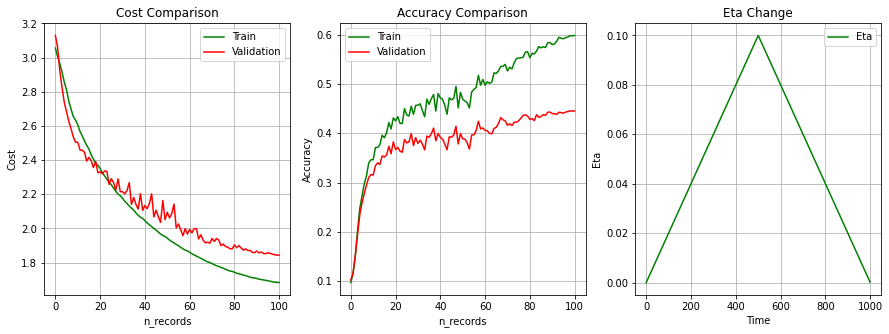

In [21]:
#### Exercise - 3 ###
# takes around 1.5 minutes
# TRAIN = VALIDATION = TEST = 10.000
# Train_Cyclical(network1, train_X_Norm, validation_X_Norm, n_cycles, n_steps)
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max, n_steps]
param_list = [network1, train_X_Norm, validation_X_Norm, 100, 1, 0.01, 100, 50, 1e-5, 1e-1, 500]
layers1, W1, b1, eta_train = Train_Cyclical(param_list, 'Batch_aggregated')

In [22]:
P_test, H_test = network1.EvaluationClassifier(layers1, test_X_Norm, W1, b1)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.4612


batch_size: 100, lambda_cost : 0.01, d: 3072, m: 50, K: 10

total_batch: 100, n_steps : 500, n_epochs: 10, n_records: 1000

record_per_cycle: 100, cost_record : 101, comparison_number: 10

epoch: 0, batch: 0, n_records: 0, cycle_step: 0
cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-19 22:37:26.571644
J_train: 3.002029409777137 ... smooth_cost : 3.002029409777137 ... J_validation: 3.110077201260018

epoch: 0, batch: 9, n_records: 9, cycle_step: 9
cycle_no: 0 ... eta: 0.00180982 ... time: 2020-08-19 22:37:27.429873
J_train: 2.905422000896207 ... smooth_cost : 3.0010633356883276 ... J_validation: 3.0470129119715095

epoch: 0, batch: 19, n_records: 19, cycle_step: 19
cycle_no: 0 ... eta: 0.00380962 ... time: 2020-08-19 22:37:28.304450
J_train: 2.9309772841753654 ... smooth_cost : 3.000362475173198 ... J_validation: 2.9282098563199455

epoch: 0, batch: 29, n_records: 29, cycle_step: 29
cycle_no: 0 ... eta: 0.00580942 ... time: 2020-08-19 22:37:29.165857
J_train: 2.7453244514369626 ... smooth

cycle_no: 0 ... eta: 0.06980302 ... time: 2020-08-19 22:37:56.191401
J_train: 1.7019467681019442 ... smooth_cost : 2.725699111931367 ... J_validation: 2.1646602766471856

epoch: 3, batch: 59, n_records: 359, cycle_step: 359
cycle_no: 0 ... eta: 0.07180282 ... time: 2020-08-19 22:37:57.025113
J_train: 1.5627251662965302 ... smooth_cost : 2.7140693724750187 ... J_validation: 2.1412475173495027

epoch: 3, batch: 69, n_records: 369, cycle_step: 369
cycle_no: 0 ... eta: 0.07380262 ... time: 2020-08-19 22:37:57.839769
J_train: 1.5728506838282312 ... smooth_cost : 2.7026571855885506 ... J_validation: 2.104044331764111

epoch: 3, batch: 79, n_records: 379, cycle_step: 379
cycle_no: 0 ... eta: 0.07580242000000001 ... time: 2020-08-19 22:37:58.656634
J_train: 1.6233644054686323 ... smooth_cost : 2.6918642577873513 ... J_validation: 2.147433708555469

epoch: 3, batch: 89, n_records: 389, cycle_step: 389
cycle_no: 0 ... eta: 0.07780222 ... time: 2020-08-19 22:37:59.478537
J_train: 1.76673759728531

cycle_no: 0 ... eta: 0.05620438 ... time: 2020-08-19 22:38:27.030836
J_train: 1.4771539421831041 ... smooth_cost : 2.335871648745407 ... J_validation: 1.9207596187982674

epoch: 7, batch: 29, n_records: 729, cycle_step: 729
cycle_no: 0 ... eta: 0.05420458 ... time: 2020-08-19 22:38:27.873370
J_train: 1.3787968609410552 ... smooth_cost : 2.3263009008673636 ... J_validation: 1.91629708491682

epoch: 7, batch: 39, n_records: 739, cycle_step: 739
cycle_no: 0 ... eta: 0.052204780000000006 ... time: 2020-08-19 22:38:28.709435
J_train: 1.3799914496304022 ... smooth_cost : 2.316837806354994 ... J_validation: 1.9007125415619046

epoch: 7, batch: 49, n_records: 749, cycle_step: 749
cycle_no: 0 ... eta: 0.05020498 ... time: 2020-08-19 22:38:29.547427
J_train: 1.44192833706592 ... smooth_cost : 2.308088711662103 ... J_validation: 1.897067993192785

epoch: 7, batch: 59, n_records: 759, cycle_step: 759
cycle_no: 0 ... eta: 0.04820518 ... time: 2020-08-19 22:38:30.394936
J_train: 1.2967891592314837 .

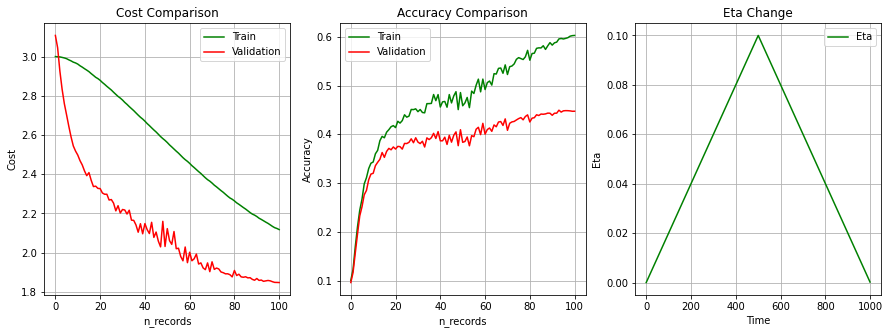

In [23]:
#### Exercise - 3 ###
# takes around 1.5 minutes
# TRAIN = VALIDATION = TEST = 10.000
# Train_Cyclical(network1, train_X_Norm, validation_X_Norm, n_cycles, n_steps)
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max, n_steps]
param_list = [network1, train_X_Norm, validation_X_Norm, 100, 1, 0.01, 100, 50, 1e-5, 1e-1, 500]
layers1, W1, b1, eta_train = Train_Cyclical(param_list, 'Batch_aggregated_ratio')

In [24]:
P_test, H_test = network1.EvaluationClassifier(layers1, test_X_Norm, W1, b1)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.4526


batch_size: 100, lambda_cost : 0.01, d: 3072, m: 50, K: 10

total_batch: 100, n_steps : 800, n_epochs: 48, n_records: 4800

record_per_cycle: 100, cost_record : 301, comparison_number: 16

epoch: 0, batch: 0, n_records: 0, cycle_step: 0
cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-19 22:39:32.126825
J_train: 3.1696708697032454 ... smooth_cost : 3.1696708697032454 ... J_validation: 3.0885109946512967

epoch: 0, batch: 15, n_records: 15, cycle_step: 15
cycle_no: 0 ... eta: 0.0018848125000000002 ... time: 2020-08-19 22:39:32.969067
J_train: 3.091303756898018 ... smooth_cost : 3.1688871985751934 ... J_validation: 3.005312137878224

epoch: 0, batch: 31, n_records: 31, cycle_step: 31
cycle_no: 0 ... eta: 0.0038846125000000006 ... time: 2020-08-19 22:39:33.813213
J_train: 2.918339171503164 ... smooth_cost : 3.166381718304473 ... J_validation: 2.877066302488571

epoch: 0, batch: 47, n_records: 47, cycle_step: 47
cycle_no: 0 ... eta: 0.0058844125 ... time: 2020-08-19 22:39:34.644868
J_train: 2.

cycle_no: 0 ... eta: 0.0698780125 ... time: 2020-08-19 22:40:01.567070
J_train: 1.44018197650739 ... smooth_cost : 2.8044718513600917 ... J_validation: 2.06025106307509

epoch: 5, batch: 75, n_records: 575, cycle_step: 575
cycle_no: 0 ... eta: 0.0718778125 ... time: 2020-08-19 22:40:02.409738
J_train: 1.6600271545416239 ... smooth_cost : 2.793027404391907 ... J_validation: 2.060719759944963

epoch: 5, batch: 91, n_records: 591, cycle_step: 591
cycle_no: 0 ... eta: 0.07387761250000001 ... time: 2020-08-19 22:40:03.252694
J_train: 1.3780039687103316 ... smooth_cost : 2.7788771700350914 ... J_validation: 2.0815945827410225

epoch: 6, batch: 7, n_records: 607, cycle_step: 607
cycle_no: 0 ... eta: 0.0758774125 ... time: 2020-08-19 22:40:04.101533
J_train: 1.6023672536889835 ... smooth_cost : 2.7671120708716304 ... J_validation: 2.0492278144244263

epoch: 6, batch: 23, n_records: 623, cycle_step: 623
cycle_no: 0 ... eta: 0.07787721250000001 ... time: 2020-08-19 22:40:04.941957
J_train: 1.380

cycle_no: 0 ... eta: 0.0581291875 ... time: 2020-08-19 22:40:32.166306
J_train: 1.2152977744156406 ... smooth_cost : 2.356743373600184 ... J_validation: 1.9043923366020241

epoch: 11, batch: 51, n_records: 1151, cycle_step: 1151
cycle_no: 0 ... eta: 0.0561293875 ... time: 2020-08-19 22:40:33.016601
J_train: 1.2987242379602084 ... smooth_cost : 2.3461631822437843 ... J_validation: 1.9338901492179463

epoch: 11, batch: 67, n_records: 1167, cycle_step: 1167
cycle_no: 0 ... eta: 0.0541295875 ... time: 2020-08-19 22:40:33.862989
J_train: 1.135225439650355 ... smooth_cost : 2.33405380481785 ... J_validation: 1.9088613696939885

epoch: 11, batch: 83, n_records: 1183, cycle_step: 1183
cycle_no: 0 ... eta: 0.052129787500000004 ... time: 2020-08-19 22:40:34.716077
J_train: 1.230103252170966 ... smooth_cost : 2.323014299291381 ... J_validation: 1.8640857304656613

epoch: 11, batch: 99, n_records: 1199, cycle_step: 1199
cycle_no: 0 ... eta: 0.0501299875 ... time: 2020-08-19 22:40:35.563364
J_train

cycle_no: 1 ... eta: 0.013883612500000002 ... time: 2020-08-19 22:41:02.867193
J_train: 1.244719112895904 ... smooth_cost : 2.035990358933007 ... J_validation: 1.8471052296967663

epoch: 17, batch: 27, n_records: 1727, cycle_step: 127
cycle_no: 1 ... eta: 0.015883412500000003 ... time: 2020-08-19 22:41:03.725328
J_train: 1.3286398929103773 ... smooth_cost : 2.0289168542727807 ... J_validation: 1.843444716299905

epoch: 17, batch: 43, n_records: 1743, cycle_step: 143
cycle_no: 1 ... eta: 0.017883212500000002 ... time: 2020-08-19 22:41:04.569195
J_train: 1.2903808388644535 ... smooth_cost : 2.0215314941186975 ... J_validation: 1.8677157359932388

epoch: 17, batch: 59, n_records: 1759, cycle_step: 159
cycle_no: 1 ... eta: 0.0198830125 ... time: 2020-08-19 22:41:05.413306
J_train: 1.220179219787007 ... smooth_cost : 2.013517971375381 ... J_validation: 1.8557182074598182

epoch: 17, batch: 75, n_records: 1775, cycle_step: 175
cycle_no: 1 ... eta: 0.0218828125 ... time: 2020-08-19 22:41:06.2

cycle_no: 1 ... eta: 0.0858764125 ... time: 2020-08-19 22:41:33.418974
J_train: 1.238121496780118 ... smooth_cost : 1.7818828659354837 ... J_validation: 2.0338753592195973

epoch: 23, batch: 3, n_records: 2303, cycle_step: 703
cycle_no: 1 ... eta: 0.08787621250000001 ... time: 2020-08-19 22:41:34.268258
J_train: 1.2195525127961653 ... smooth_cost : 1.7762595624040907 ... J_validation: 2.021620320579399

epoch: 23, batch: 19, n_records: 2319, cycle_step: 719
cycle_no: 1 ... eta: 0.0898760125 ... time: 2020-08-19 22:41:35.111217
J_train: 1.2359138956504576 ... smooth_cost : 1.7708561057365542 ... J_validation: 2.132952036209463

epoch: 23, batch: 35, n_records: 2335, cycle_step: 735
cycle_no: 1 ... eta: 0.0918758125 ... time: 2020-08-19 22:41:35.955763
J_train: 1.24698249413035 ... smooth_cost : 1.7656173696204922 ... J_validation: 2.1168264020725354

epoch: 23, batch: 51, n_records: 2351, cycle_step: 751
cycle_no: 1 ... eta: 0.0938756125 ... time: 2020-08-19 22:41:36.798154
J_train: 1.2

cycle_no: 1 ... eta: 0.0421307875 ... time: 2020-08-19 22:42:04.347006
J_train: 1.0961207305060598 ... smooth_cost : 1.6026629671922605 ... J_validation: 1.9319599124500855

epoch: 28, batch: 79, n_records: 2879, cycle_step: 1279
cycle_no: 1 ... eta: 0.0401309875 ... time: 2020-08-19 22:42:05.203741
J_train: 1.2468608705020194 ... smooth_cost : 1.599104946225358 ... J_validation: 1.917312890740461

epoch: 28, batch: 95, n_records: 2895, cycle_step: 1295
cycle_no: 1 ... eta: 0.0381311875 ... time: 2020-08-19 22:42:06.044663
J_train: 1.1318408654699668 ... smooth_cost : 1.594432305417804 ... J_validation: 1.928408113618325

epoch: 29, batch: 11, n_records: 2911, cycle_step: 1311
cycle_no: 1 ... eta: 0.0361313875 ... time: 2020-08-19 22:42:06.896942
J_train: 1.1290137340143327 ... smooth_cost : 1.5897781197037693 ... J_validation: 1.9366176672975215

epoch: 29, batch: 27, n_records: 2927, cycle_step: 1327
cycle_no: 1 ... eta: 0.034131587500000005 ... time: 2020-08-19 22:42:07.777473
J_tra

cycle_no: 2 ... eta: 0.029882012500000003 ... time: 2020-08-19 22:42:35.020285
J_train: 1.155814261168091 ... smooth_cost : 1.4922677344068294 ... J_validation: 1.9290703495372878

epoch: 34, batch: 55, n_records: 3455, cycle_step: 255
cycle_no: 2 ... eta: 0.0318818125 ... time: 2020-08-19 22:42:35.871397
J_train: 1.1493291277722384 ... smooth_cost : 1.4888383483404835 ... J_validation: 1.9514130028487426

epoch: 34, batch: 71, n_records: 3471, cycle_step: 271
cycle_no: 2 ... eta: 0.033881612500000005 ... time: 2020-08-19 22:42:36.718663
J_train: 1.0277317642004953 ... smooth_cost : 1.4842272824990836 ... J_validation: 1.9660301441776311

epoch: 34, batch: 87, n_records: 3487, cycle_step: 287
cycle_no: 2 ... eta: 0.03588141250000001 ... time: 2020-08-19 22:42:37.562142
J_train: 1.2233086322552182 ... smooth_cost : 1.481618095996645 ... J_validation: 1.944988479225603

epoch: 35, batch: 3, n_records: 3503, cycle_step: 303
cycle_no: 2 ... eta: 0.037881212500000004 ... time: 2020-08-19 22

cycle_no: 2 ... eta: 0.0981251875 ... time: 2020-08-19 22:43:05.424344
J_train: 1.1811540452527725 ... smooth_cost : 1.3989436650978562 ... J_validation: 2.0586601710645174

epoch: 40, batch: 31, n_records: 4031, cycle_step: 831
cycle_no: 2 ... eta: 0.0961253875 ... time: 2020-08-19 22:43:06.273187
J_train: 1.3621623973718742 ... smooth_cost : 1.3985758524205965 ... J_validation: 2.235777884625691

epoch: 40, batch: 47, n_records: 4047, cycle_step: 847
cycle_no: 2 ... eta: 0.09412558750000001 ... time: 2020-08-19 22:43:07.106829
J_train: 1.1930077039390572 ... smooth_cost : 1.396520170935781 ... J_validation: 2.1426984379100245

epoch: 40, batch: 63, n_records: 4063, cycle_step: 863
cycle_no: 2 ... eta: 0.0921257875 ... time: 2020-08-19 22:43:07.955387
J_train: 1.1003877096797294 ... smooth_cost : 1.3935588463232205 ... J_validation: 2.066154968446095

epoch: 40, batch: 79, n_records: 4079, cycle_step: 879
cycle_no: 2 ... eta: 0.0901259875 ... time: 2020-08-19 22:43:08.798371
J_train: 

cycle_no: 2 ... eta: 0.026132387499999993 ... time: 2020-08-19 22:43:35.777301
J_train: 1.1547917371016063 ... smooth_cost : 1.3316236684115952 ... J_validation: 1.9529652418953016

epoch: 46, batch: 7, n_records: 4607, cycle_step: 1407
cycle_no: 2 ... eta: 0.024132587499999997 ... time: 2020-08-19 22:43:36.616723
J_train: 1.2410603835576024 ... smooth_cost : 1.3307180355630552 ... J_validation: 1.9370926923086218

epoch: 46, batch: 23, n_records: 4623, cycle_step: 1423
cycle_no: 2 ... eta: 0.022132787499999987 ... time: 2020-08-19 22:43:37.454244
J_train: 1.1361896250184778 ... smooth_cost : 1.3287727514576093 ... J_validation: 1.9427932710570972

epoch: 46, batch: 39, n_records: 4639, cycle_step: 1439
cycle_no: 2 ... eta: 0.020132987500000005 ... time: 2020-08-19 22:43:38.295638
J_train: 1.2363433951323928 ... smooth_cost : 1.327848457894357 ... J_validation: 1.9277949931075407

epoch: 46, batch: 55, n_records: 4655, cycle_step: 1455
cycle_no: 2 ... eta: 0.018133187499999995 ... time

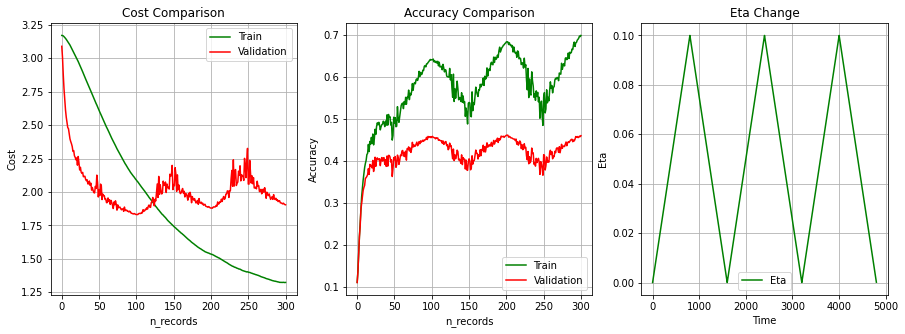

In [25]:
### Exercise - 4 _ Part1 ###
# takes around 4.5 minutes
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max, n_steps]
param_list = [network1, train_X_Norm, validation_X_Norm, 100, 3, 0.01, 100, 50, 1e-5, 1e-1, 800]
layers2, W2, b2, eta_train = Train_Cyclical(param_list, 'Batch_aggregated_ratio')

In [26]:
P_test, H_test = network1.EvaluationClassifier(layers2, test_X_Norm, W2, b2)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.4636


batch_size: 100, lambda_cost : 0.01, d: 3072, m: 50, K: 10

total_batch: 100, n_steps : 800, n_epochs: 48, n_records: 4800

record_per_cycle: 100, cost_record : 301, comparison_number: 16

epoch: 0, batch: 0, n_records: 0, cycle_step: 0
cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-19 22:44:14.066394
J_train: 3.125009318124455 ... smooth_cost : 0 ... J_validation: 3.1234999801306786

epoch: 0, batch: 15, n_records: 15, cycle_step: 15
cycle_no: 0 ... eta: 0.0018848125000000002 ... time: 2020-08-19 22:44:15.641822
J_train: 2.992734913993531 ... smooth_cost : 0 ... J_validation: 2.996018354874696

epoch: 0, batch: 31, n_records: 31, cycle_step: 31
cycle_no: 0 ... eta: 0.0038846125000000006 ... time: 2020-08-19 22:44:17.215821
J_train: 2.8460682420619077 ... smooth_cost : 0 ... J_validation: 2.859698003334153

epoch: 0, batch: 47, n_records: 47, cycle_step: 47
cycle_no: 0 ... eta: 0.0058844125 ... time: 2020-08-19 22:44:18.799895
J_train: 2.7342862797363767 ... smooth_cost : 0 ... J_validat

cycle_no: 0 ... eta: 0.0758774125 ... time: 2020-08-19 22:45:14.467478
J_train: 1.7854675280574923 ... smooth_cost : 0 ... J_validation: 2.05334655299881

epoch: 6, batch: 23, n_records: 623, cycle_step: 623
cycle_no: 0 ... eta: 0.07787721250000001 ... time: 2020-08-19 22:45:16.066419
J_train: 1.78763753027867 ... smooth_cost : 0 ... J_validation: 2.050614184371848

epoch: 6, batch: 39, n_records: 639, cycle_step: 639
cycle_no: 0 ... eta: 0.0798770125 ... time: 2020-08-19 22:45:17.671996
J_train: 1.7687092903198227 ... smooth_cost : 0 ... J_validation: 2.0242006227732006

epoch: 6, batch: 55, n_records: 655, cycle_step: 655
cycle_no: 0 ... eta: 0.0818768125 ... time: 2020-08-19 22:45:19.274569
J_train: 1.7429617330921767 ... smooth_cost : 0 ... J_validation: 2.0228603781672856

epoch: 6, batch: 71, n_records: 671, cycle_step: 671
cycle_no: 0 ... eta: 0.0838766125 ... time: 2020-08-19 22:45:20.869838
J_train: 1.7214915277790404 ... smooth_cost : 0 ... J_validation: 1.999933957971963

ep

cycle_no: 0 ... eta: 0.04613038750000001 ... time: 2020-08-19 22:46:16.837064
J_train: 1.4705616892636928 ... smooth_cost : 0 ... J_validation: 1.8687478928903494

epoch: 12, batch: 47, n_records: 1247, cycle_step: 1247
cycle_no: 0 ... eta: 0.044130587500000006 ... time: 2020-08-19 22:46:18.419973
J_train: 1.4727564628914727 ... smooth_cost : 0 ... J_validation: 1.887632544499629

epoch: 12, batch: 63, n_records: 1263, cycle_step: 1263
cycle_no: 0 ... eta: 0.0421307875 ... time: 2020-08-19 22:46:20.010818
J_train: 1.4590089875652277 ... smooth_cost : 0 ... J_validation: 1.8729598256346878

epoch: 12, batch: 79, n_records: 1279, cycle_step: 1279
cycle_no: 0 ... eta: 0.0401309875 ... time: 2020-08-19 22:46:21.596166
J_train: 1.4408931629278952 ... smooth_cost : 0 ... J_validation: 1.8670848230057655

epoch: 12, batch: 95, n_records: 1295, cycle_step: 1295
cycle_no: 0 ... eta: 0.0381311875 ... time: 2020-08-19 22:46:23.181396
J_train: 1.466311465325228 ... smooth_cost : 0 ... J_validation

cycle_no: 1 ... eta: 0.029882012500000003 ... time: 2020-08-19 22:47:17.250900
J_train: 1.392411691057956 ... smooth_cost : 0 ... J_validation: 1.8732813648986342

epoch: 18, batch: 55, n_records: 1855, cycle_step: 255
cycle_no: 1 ... eta: 0.0318818125 ... time: 2020-08-19 22:47:18.828228
J_train: 1.3984306046220554 ... smooth_cost : 0 ... J_validation: 1.8877089580406956

epoch: 18, batch: 71, n_records: 1871, cycle_step: 271
cycle_no: 1 ... eta: 0.033881612500000005 ... time: 2020-08-19 22:47:20.415904
J_train: 1.4084690912890983 ... smooth_cost : 0 ... J_validation: 1.8918085696354099

epoch: 18, batch: 87, n_records: 1887, cycle_step: 287
cycle_no: 1 ... eta: 0.03588141250000001 ... time: 2020-08-19 22:47:22.010558
J_train: 1.4031409744793588 ... smooth_cost : 0 ... J_validation: 1.8919461064109486

epoch: 19, batch: 3, n_records: 1903, cycle_step: 303
cycle_no: 1 ... eta: 0.037881212500000004 ... time: 2020-08-19 22:47:23.605887
J_train: 1.4044766681322278 ... smooth_cost : 0 ... 

cycle_no: 1 ... eta: 0.0921257875 ... time: 2020-08-19 22:48:19.396642
J_train: 1.523596224251798 ... smooth_cost : 0 ... J_validation: 1.981006261832953

epoch: 24, batch: 79, n_records: 2479, cycle_step: 879
cycle_no: 1 ... eta: 0.0901259875 ... time: 2020-08-19 22:48:20.975327
J_train: 1.5882121304311483 ... smooth_cost : 0 ... J_validation: 2.0563380502808095

epoch: 24, batch: 95, n_records: 2495, cycle_step: 895
cycle_no: 1 ... eta: 0.08812618750000001 ... time: 2020-08-19 22:48:22.556227
J_train: 1.5762679803090434 ... smooth_cost : 0 ... J_validation: 2.0273603996065015

epoch: 25, batch: 11, n_records: 2511, cycle_step: 911
cycle_no: 1 ... eta: 0.0861263875 ... time: 2020-08-19 22:48:24.141800
J_train: 1.58151604871624 ... smooth_cost : 0 ... J_validation: 2.033122570867049

epoch: 25, batch: 27, n_records: 2527, cycle_step: 927
cycle_no: 1 ... eta: 0.0841265875 ... time: 2020-08-19 22:48:25.739058
J_train: 1.5787208943706224 ... smooth_cost : 0 ... J_validation: 2.03107730752

cycle_no: 1 ... eta: 0.014133587500000003 ... time: 2020-08-19 22:49:21.256843
J_train: 1.3331546264630088 ... smooth_cost : 0 ... J_validation: 1.9121357310326965

epoch: 31, batch: 3, n_records: 3103, cycle_step: 1503
cycle_no: 1 ... eta: 0.012133787499999993 ... time: 2020-08-19 22:49:22.833101
J_train: 1.330345334846403 ... smooth_cost : 0 ... J_validation: 1.909601383212665

epoch: 31, batch: 19, n_records: 3119, cycle_step: 1519
cycle_no: 1 ... eta: 0.010133987499999997 ... time: 2020-08-19 22:49:24.428866
J_train: 1.3235171576918277 ... smooth_cost : 0 ... J_validation: 1.9054458595142725

epoch: 31, batch: 35, n_records: 3135, cycle_step: 1535
cycle_no: 1 ... eta: 0.0081341875 ... time: 2020-08-19 22:49:26.012417
J_train: 1.3205695005912936 ... smooth_cost : 0 ... J_validation: 1.9033577556509946

epoch: 31, batch: 51, n_records: 3151, cycle_step: 1551
cycle_no: 1 ... eta: 0.006134387500000005 ... time: 2020-08-19 22:49:27.594920
J_train: 1.3160184871129086 ... smooth_cost : 0 

cycle_no: 2 ... eta: 0.06187881250000001 ... time: 2020-08-19 22:50:21.966759
J_train: 1.4921529008821126 ... smooth_cost : 0 ... J_validation: 2.0735641065512946

epoch: 37, batch: 11, n_records: 3711, cycle_step: 511
cycle_no: 2 ... eta: 0.0638786125 ... time: 2020-08-19 22:50:23.536301
J_train: 1.630179021118338 ... smooth_cost : 0 ... J_validation: 2.2033463445715737

epoch: 37, batch: 27, n_records: 3727, cycle_step: 527
cycle_no: 2 ... eta: 0.0658784125 ... time: 2020-08-19 22:50:25.126566
J_train: 1.5579105340302672 ... smooth_cost : 0 ... J_validation: 2.119718353188798

epoch: 37, batch: 43, n_records: 3743, cycle_step: 543
cycle_no: 2 ... eta: 0.0678782125 ... time: 2020-08-19 22:50:26.703917
J_train: 1.4995337557145352 ... smooth_cost : 0 ... J_validation: 2.080888332667417

epoch: 37, batch: 59, n_records: 3759, cycle_step: 559
cycle_no: 2 ... eta: 0.0698780125 ... time: 2020-08-19 22:50:28.293570
J_train: 1.489998043614295 ... smooth_cost : 0 ... J_validation: 2.0698137586

cycle_no: 2 ... eta: 0.0601289875 ... time: 2020-08-19 22:51:23.832546
J_train: 1.464788569605763 ... smooth_cost : 0 ... J_validation: 2.018240709179434

epoch: 43, batch: 35, n_records: 4335, cycle_step: 1135
cycle_no: 2 ... eta: 0.0581291875 ... time: 2020-08-19 22:51:25.424279
J_train: 1.4832761654172961 ... smooth_cost : 0 ... J_validation: 2.03953802829224

epoch: 43, batch: 51, n_records: 4351, cycle_step: 1151
cycle_no: 2 ... eta: 0.0561293875 ... time: 2020-08-19 22:51:27.008895
J_train: 1.4760462049564762 ... smooth_cost : 0 ... J_validation: 2.0440957475963475

epoch: 43, batch: 67, n_records: 4367, cycle_step: 1167
cycle_no: 2 ... eta: 0.0541295875 ... time: 2020-08-19 22:51:28.587327
J_train: 1.4490998995523037 ... smooth_cost : 0 ... J_validation: 2.0204851918492297

epoch: 43, batch: 83, n_records: 4383, cycle_step: 1183
cycle_no: 2 ... eta: 0.052129787500000004 ... time: 2020-08-19 22:51:30.175743
J_train: 1.4269694567493865 ... smooth_cost : 0 ... J_validation: 1.98521

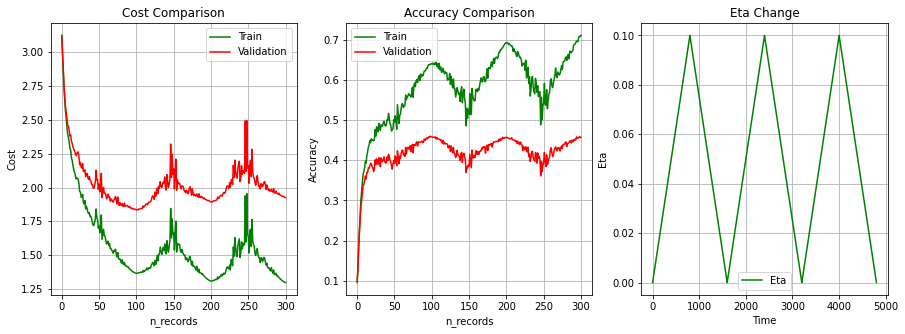

In [27]:
### Exercise - 4 _ Part1 ###
# takes around 8.5 minutes
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max, n_steps]
param_list = [network1, train_X_Norm, validation_X_Norm, 100, 3, 0.01, 100, 50, 1e-5, 1e-1, 800]
layers2, W2, b2, eta_train = Train_Cyclical(param_list, 'ALL_Data')

In [28]:
P_test, H_test = network1.EvaluationClassifier(layers2, test_X_Norm, W2, b2)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.4599


batch_size: 100, lambda_cost : 0.01, d: 3072, m: 50, K: 10

total_batch: 100, n_steps : 800, n_epochs: 48, n_records: 4800

record_per_cycle: 100, cost_record : 301, comparison_number: 16

epoch: 0, batch: 0, n_records: 0, cycle_step: 0
cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-19 22:52:57.860743
J_train: 3.07884382425509 ... smooth_cost : 3.07884382425509 ... J_validation: 3.09087177012941

epoch: 0, batch: 15, n_records: 15, cycle_step: 15
cycle_no: 0 ... eta: 0.0018848125000000002 ... time: 2020-08-19 22:52:58.693448
J_train: 2.951583108464428 ... smooth_cost : 3.015213466359759 ... J_validation: 2.990806155702849

epoch: 0, batch: 31, n_records: 31, cycle_step: 31
cycle_no: 0 ... eta: 0.0038846125000000006 ... time: 2020-08-19 22:52:59.520086
J_train: 2.8300943135230487 ... smooth_cost : 2.9535070820808556 ... J_validation: 2.8600421964754985

epoch: 0, batch: 47, n_records: 47, cycle_step: 47
cycle_no: 0 ... eta: 0.0058844125 ... time: 2020-08-19 22:53:00.342321
J_train: 2.6327

cycle_no: 0 ... eta: 0.0698780125 ... time: 2020-08-19 22:53:26.847565
J_train: 1.3818185530445866 ... smooth_cost : 1.9898904595630036 ... J_validation: 2.042024971379868

epoch: 5, batch: 75, n_records: 575, cycle_step: 575
cycle_no: 0 ... eta: 0.0718778125 ... time: 2020-08-19 22:53:27.681266
J_train: 1.607877519538278 ... smooth_cost : 1.9795657855082813 ... J_validation: 2.0986633032330806

epoch: 5, batch: 91, n_records: 591, cycle_step: 591
cycle_no: 0 ... eta: 0.07387761250000001 ... time: 2020-08-19 22:53:28.518486
J_train: 1.3746328896790558 ... smooth_cost : 1.9636464987759334 ... J_validation: 2.072263503129787

epoch: 6, batch: 7, n_records: 607, cycle_step: 607
cycle_no: 0 ... eta: 0.0758774125 ... time: 2020-08-19 22:53:29.347961
J_train: 1.576917040205922 ... smooth_cost : 1.9537303588125998 ... J_validation: 2.0720966981676208

epoch: 6, batch: 23, n_records: 623, cycle_step: 623
cycle_no: 0 ... eta: 0.07787721250000001 ... time: 2020-08-19 22:53:30.187022
J_train: 1.4

cycle_no: 0 ... eta: 0.0581291875 ... time: 2020-08-19 22:53:57.419342
J_train: 1.2468561358257075 ... smooth_cost : 1.6658967775000952 ... J_validation: 1.913261231707546

epoch: 11, batch: 51, n_records: 1151, cycle_step: 1151
cycle_no: 0 ... eta: 0.0561293875 ... time: 2020-08-19 22:53:58.279798
J_train: 1.309897913664652 ... smooth_cost : 1.6610200807352262 ... J_validation: 1.9409773805933712

epoch: 11, batch: 67, n_records: 1167, cycle_step: 1167
cycle_no: 0 ... eta: 0.0541295875 ... time: 2020-08-19 22:53:59.122826
J_train: 1.1586450935640997 ... smooth_cost : 1.654231229557238 ... J_validation: 1.9134992090605967

epoch: 11, batch: 83, n_records: 1183, cycle_step: 1183
cycle_no: 0 ... eta: 0.052129787500000004 ... time: 2020-08-19 22:53:59.973860
J_train: 1.2204866753263646 ... smooth_cost : 1.6484479688341598 ... J_validation: 1.8759829984273217

epoch: 11, batch: 99, n_records: 1199, cycle_step: 1199
cycle_no: 0 ... eta: 0.0501299875 ... time: 2020-08-19 22:54:00.811256
J_tr

cycle_no: 1 ... eta: 0.013883612500000002 ... time: 2020-08-19 22:54:27.966407
J_train: 1.2385297776966615 ... smooth_cost : 1.5433101955668245 ... J_validation: 1.8442071522301275

epoch: 17, batch: 27, n_records: 1727, cycle_step: 127
cycle_no: 1 ... eta: 0.015883412500000003 ... time: 2020-08-19 22:54:28.834871
J_train: 1.3893685088550343 ... smooth_cost : 1.5418978865144226 ... J_validation: 1.849865597869388

epoch: 17, batch: 43, n_records: 1743, cycle_step: 143
cycle_no: 1 ... eta: 0.017883212500000002 ... time: 2020-08-19 22:54:29.675157
J_train: 1.2517741448876176 ... smooth_cost : 1.5392603979541788 ... J_validation: 1.8699890408003883

epoch: 17, batch: 59, n_records: 1759, cycle_step: 159
cycle_no: 1 ... eta: 0.0198830125 ... time: 2020-08-19 22:54:30.517700
J_train: 1.2111656759389924 ... smooth_cost : 1.5363045896477356 ... J_validation: 1.8597857198999557

epoch: 17, batch: 75, n_records: 1775, cycle_step: 175
cycle_no: 1 ... eta: 0.0218828125 ... time: 2020-08-19 22:54:

cycle_no: 1 ... eta: 0.0858764125 ... time: 2020-08-19 22:54:58.497243
J_train: 1.2822266093230343 ... smooth_cost : 1.4577042102041398 ... J_validation: 1.9875049046469857

epoch: 23, batch: 3, n_records: 2303, cycle_step: 703
cycle_no: 1 ... eta: 0.08787621250000001 ... time: 2020-08-19 22:54:59.352094
J_train: 1.1809623248373224 ... smooth_cost : 1.455795645477472 ... J_validation: 2.0386105038308004

epoch: 23, batch: 19, n_records: 2319, cycle_step: 719
cycle_no: 1 ... eta: 0.0898760125 ... time: 2020-08-19 22:55:00.200636
J_train: 1.1770832556870952 ... smooth_cost : 1.453886656506305 ... J_validation: 2.068720664045849

epoch: 23, batch: 35, n_records: 2335, cycle_step: 735
cycle_no: 1 ... eta: 0.0918758125 ... time: 2020-08-19 22:55:01.049023
J_train: 1.4213587359212925 ... smooth_cost : 1.4536653781349786 ... J_validation: 2.2629362897599745

epoch: 23, batch: 51, n_records: 2351, cycle_step: 751
cycle_no: 1 ... eta: 0.0938756125 ... time: 2020-08-19 22:55:01.890517
J_train: 1

cycle_no: 1 ... eta: 0.0421307875 ... time: 2020-08-19 22:55:28.930466
J_train: 1.071794170298583 ... smooth_cost : 1.4075477777215588 ... J_validation: 1.9395693539252477

epoch: 28, batch: 79, n_records: 2879, cycle_step: 1279
cycle_no: 1 ... eta: 0.0401309875 ... time: 2020-08-19 22:55:29.775090
J_train: 1.2277917349629113 ... smooth_cost : 1.4065546504135 ... J_validation: 1.9292030012824717

epoch: 28, batch: 95, n_records: 2895, cycle_step: 1295
cycle_no: 1 ... eta: 0.0381311875 ... time: 2020-08-19 22:55:30.616031
J_train: 1.0808620028400255 ... smooth_cost : 1.4047651303718875 ... J_validation: 1.939749572318689

epoch: 29, batch: 11, n_records: 2911, cycle_step: 1311
cycle_no: 1 ... eta: 0.0361313875 ... time: 2020-08-19 22:55:31.461861
J_train: 1.1072330291447312 ... smooth_cost : 1.4031392718952365 ... J_validation: 1.9158187207023518

epoch: 29, batch: 27, n_records: 2927, cycle_step: 1327
cycle_no: 1 ... eta: 0.034131587500000005 ... time: 2020-08-19 22:55:32.303425
J_trai

cycle_no: 2 ... eta: 0.029882012500000003 ... time: 2020-08-19 22:55:59.483533
J_train: 1.1039208850114326 ... smooth_cost : 1.37862911313632 ... J_validation: 1.9333800434946995

epoch: 34, batch: 55, n_records: 3455, cycle_step: 255
cycle_no: 2 ... eta: 0.0318818125 ... time: 2020-08-19 22:56:00.333953
J_train: 1.1718847843845994 ... smooth_cost : 1.377676374294146 ... J_validation: 1.9614936314534985

epoch: 34, batch: 71, n_records: 3471, cycle_step: 271
cycle_no: 2 ... eta: 0.033881612500000005 ... time: 2020-08-19 22:56:01.166412
J_train: 1.0672665830328647 ... smooth_cost : 1.3762524761690942 ... J_validation: 1.9633055032413396

epoch: 34, batch: 87, n_records: 3487, cycle_step: 287
cycle_no: 2 ... eta: 0.03588141250000001 ... time: 2020-08-19 22:56:02.007954
J_train: 1.2581996131834292 ... smooth_cost : 1.3757134220002099 ... J_validation: 1.955510377661137

epoch: 35, batch: 3, n_records: 3503, cycle_step: 303
cycle_no: 2 ... eta: 0.037881212500000004 ... time: 2020-08-19 22:

cycle_no: 2 ... eta: 0.0981251875 ... time: 2020-08-19 22:56:29.837623
J_train: 1.1373157349646965 ... smooth_cost : 1.3540730933758427 ... J_validation: 2.080003445344633

epoch: 40, batch: 31, n_records: 4031, cycle_step: 831
cycle_no: 2 ... eta: 0.0961253875 ... time: 2020-08-19 22:56:30.688907
J_train: 1.5521599057340296 ... smooth_cost : 1.3548560452033453 ... J_validation: 2.3356585019447182

epoch: 40, batch: 47, n_records: 4047, cycle_step: 847
cycle_no: 2 ... eta: 0.09412558750000001 ... time: 2020-08-19 22:56:31.533603
J_train: 1.3017907909726298 ... smooth_cost : 1.3546471268796023 ... J_validation: 2.293115292598155

epoch: 40, batch: 63, n_records: 4063, cycle_step: 863
cycle_no: 2 ... eta: 0.0921257875 ... time: 2020-08-19 22:56:32.374815
J_train: 1.0999515389118077 ... smooth_cost : 1.3536483206522776 ... J_validation: 2.0746310860920296

epoch: 40, batch: 79, n_records: 4079, cycle_step: 879
cycle_no: 2 ... eta: 0.0901259875 ... time: 2020-08-19 22:56:33.213595
J_train:

cycle_no: 2 ... eta: 0.026132387499999993 ... time: 2020-08-19 22:57:00.286538
J_train: 1.1784357829594907 ... smooth_cost : 1.33324776036495 ... J_validation: 1.9563136056206598

epoch: 46, batch: 7, n_records: 4607, cycle_step: 1407
cycle_no: 2 ... eta: 0.024132587499999997 ... time: 2020-08-19 22:57:01.124529
J_train: 1.2254110876711952 ... smooth_cost : 1.332874623089193 ... J_validation: 1.9396593185611464

epoch: 46, batch: 23, n_records: 4623, cycle_step: 1423
cycle_no: 2 ... eta: 0.022132787499999987 ... time: 2020-08-19 22:57:01.964312
J_train: 1.1982665177479583 ... smooth_cost : 1.332410457208706 ... J_validation: 1.9394698558531154

epoch: 46, batch: 39, n_records: 4639, cycle_step: 1439
cycle_no: 2 ... eta: 0.020132987500000005 ... time: 2020-08-19 22:57:02.804610
J_train: 1.1544691784124232 ... smooth_cost : 1.3317989751509869 ... J_validation: 1.936942041298869

epoch: 46, batch: 55, n_records: 4655, cycle_step: 1455
cycle_no: 2 ... eta: 0.018133187499999995 ... time: 20

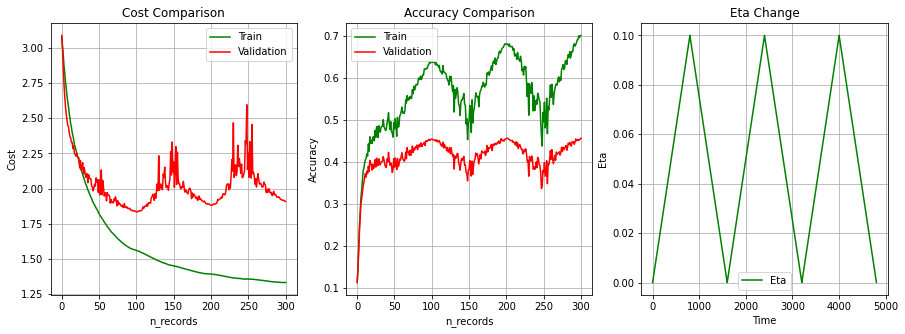

In [29]:
### Exercise - 4 _ Part1 ###
# takes around 4.5 minutes
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max, n_steps]
param_list = [network1, train_X_Norm, validation_X_Norm, 100, 3, 0.01, 100, 50, 1e-5, 1e-1, 800]
layers2, W2, b2, eta_train = Train_Cyclical(param_list, 'Batch_aggregated')

In [30]:
P_test, H_test = network1.EvaluationClassifier(layers2, test_X_Norm, W2, b2)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.4641


batch_size: 100, lambda_cost : 0.01, d: 3072, m: 100, K: 10

total_batch: 100, n_steps : 800, n_epochs: 48, n_records: 4800

record_per_cycle: 100, cost_record : 301, comparison_number: 16

epoch: 0, batch: 0, n_records: 0, cycle_step: 0
cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-19 23:06:05.504578
J_train: 3.5211202657475154 ... smooth_cost : 3.5211202657475154 ... J_validation: 3.6351140597798723

epoch: 0, batch: 15, n_records: 15, cycle_step: 15
cycle_no: 0 ... eta: 0.0018848125000000002 ... time: 2020-08-19 23:06:06.442296
J_train: 3.4736747732453495 ... smooth_cost : 3.4973975194964324 ... J_validation: 3.52931140190977

epoch: 0, batch: 31, n_records: 31, cycle_step: 31
cycle_no: 0 ... eta: 0.0038846125000000006 ... time: 2020-08-19 23:06:07.402172
J_train: 3.325416837030412 ... smooth_cost : 3.4400706253410918 ... J_validation: 3.372709731302025

epoch: 0, batch: 47, n_records: 47, cycle_step: 47
cycle_no: 0 ... eta: 0.0058844125 ... time: 2020-08-19 23:06:08.333630
J_train: 

cycle_no: 0 ... eta: 0.0698780125 ... time: 2020-08-19 23:06:37.884039
J_train: 1.5676227978549349 ... smooth_cost : 2.3572286750259743 ... J_validation: 2.315262707017128

epoch: 5, batch: 75, n_records: 575, cycle_step: 575
cycle_no: 0 ... eta: 0.0718778125 ... time: 2020-08-19 23:06:38.826690
J_train: 1.7990918908414826 ... smooth_cost : 2.3421438970750423 ... J_validation: 2.3123672391436685

epoch: 5, batch: 91, n_records: 591, cycle_step: 591
cycle_no: 0 ... eta: 0.07387761250000001 ... time: 2020-08-19 23:06:39.827882
J_train: 1.5653812884303013 ... smooth_cost : 2.3217027757949174 ... J_validation: 2.2723814658487296

epoch: 6, batch: 7, n_records: 607, cycle_step: 607
cycle_no: 0 ... eta: 0.0758774125 ... time: 2020-08-19 23:06:40.789738
J_train: 1.6772443146867837 ... smooth_cost : 2.305178199869068 ... J_validation: 2.264513595123522

epoch: 6, batch: 23, n_records: 623, cycle_step: 623
cycle_no: 0 ... eta: 0.07787721250000001 ... time: 2020-08-19 23:06:41.742397
J_train: 1.

cycle_no: 0 ... eta: 0.0581291875 ... time: 2020-08-19 23:07:12.329754
J_train: 1.155221350662539 ... smooth_cost : 1.862168654581785 ... J_validation: 1.9582018881193086

epoch: 11, batch: 51, n_records: 1151, cycle_step: 1151
cycle_no: 0 ... eta: 0.0561293875 ... time: 2020-08-19 23:07:13.287776
J_train: 1.2731691400212597 ... smooth_cost : 1.854100168080956 ... J_validation: 2.016636765667773

epoch: 11, batch: 67, n_records: 1167, cycle_step: 1167
cycle_no: 0 ... eta: 0.0541295875 ... time: 2020-08-19 23:07:14.242884
J_train: 1.1246536899931914 ... smooth_cost : 1.844242783241932 ... J_validation: 1.967225093603817

epoch: 11, batch: 83, n_records: 1183, cycle_step: 1183
cycle_no: 0 ... eta: 0.052129787500000004 ... time: 2020-08-19 23:07:15.208202
J_train: 1.1031098782317248 ... smooth_cost : 1.834361011175129 ... J_validation: 1.9275762312806521

epoch: 11, batch: 99, n_records: 1199, cycle_step: 1199
cycle_no: 0 ... eta: 0.0501299875 ... time: 2020-08-19 23:07:16.165422
J_train:

cycle_no: 1 ... eta: 0.013883612500000002 ... time: 2020-08-19 23:07:47.172163
J_train: 1.2517388178204185 ... smooth_cost : 1.6561025716646665 ... J_validation: 1.8923326082685428

epoch: 17, batch: 27, n_records: 1727, cycle_step: 127
cycle_no: 1 ... eta: 0.015883412500000003 ... time: 2020-08-19 23:07:48.171478
J_train: 1.300209361874418 ... smooth_cost : 1.6528374963454897 ... J_validation: 1.89918222925001

epoch: 17, batch: 43, n_records: 1743, cycle_step: 143
cycle_no: 1 ... eta: 0.017883212500000002 ... time: 2020-08-19 23:07:49.161088
J_train: 1.1840021932518916 ... smooth_cost : 1.648575357226457 ... J_validation: 1.9142072797727627

epoch: 17, batch: 59, n_records: 1759, cycle_step: 159
cycle_no: 1 ... eta: 0.0198830125 ... time: 2020-08-19 23:07:50.128252
J_train: 1.1626408316712729 ... smooth_cost : 1.6441975687079418 ... J_validation: 1.9053860601567627

epoch: 17, batch: 75, n_records: 1775, cycle_step: 175
cycle_no: 1 ... eta: 0.0218828125 ... time: 2020-08-19 23:07:51.

cycle_no: 1 ... eta: 0.0858764125 ... time: 2020-08-19 23:08:22.761287
J_train: 1.154715808712591 ... smooth_cost : 1.520940781720364 ... J_validation: 2.136615430763785

epoch: 23, batch: 3, n_records: 2303, cycle_step: 703
cycle_no: 1 ... eta: 0.08787621250000001 ... time: 2020-08-19 23:08:23.705556
J_train: 1.2371041786594168 ... smooth_cost : 1.5189832879061507 ... J_validation: 2.1555950787566536

epoch: 23, batch: 19, n_records: 2319, cycle_step: 719
cycle_no: 1 ... eta: 0.0898760125 ... time: 2020-08-19 23:08:24.653719
J_train: 1.116642717051202 ... smooth_cost : 1.5162275305715278 ... J_validation: 2.161160304566253

epoch: 23, batch: 35, n_records: 2335, cycle_step: 735
cycle_no: 1 ... eta: 0.0918758125 ... time: 2020-08-19 23:08:25.606850
J_train: 1.4029246796944734 ... smooth_cost : 1.5154567628784865 ... J_validation: 2.4466497756615713

epoch: 23, batch: 51, n_records: 2351, cycle_step: 751
cycle_no: 1 ... eta: 0.0938756125 ... time: 2020-08-19 23:08:26.555211
J_train: 1.2

cycle_no: 1 ... eta: 0.0421307875 ... time: 2020-08-19 23:08:57.101726
J_train: 1.0142902875513164 ... smooth_cost : 1.4400802050316805 ... J_validation: 1.9961438783883083

epoch: 28, batch: 79, n_records: 2879, cycle_step: 1279
cycle_no: 1 ... eta: 0.0401309875 ... time: 2020-08-19 23:08:58.050866
J_train: 1.1634913146014572 ... smooth_cost : 1.4385520896149389 ... J_validation: 1.988092607649255

epoch: 28, batch: 95, n_records: 2895, cycle_step: 1295
cycle_no: 1 ... eta: 0.0381311875 ... time: 2020-08-19 23:08:58.990678
J_train: 1.0598362146300428 ... smooth_cost : 1.4364712331589777 ... J_validation: 1.9966398588125478

epoch: 29, batch: 11, n_records: 2911, cycle_step: 1311
cycle_no: 1 ... eta: 0.0361313875 ... time: 2020-08-19 23:08:59.934287
J_train: 1.1220541508887765 ... smooth_cost : 1.434753107026354 ... J_validation: 1.9864880996164969

epoch: 29, batch: 27, n_records: 2927, cycle_step: 1327
cycle_no: 1 ... eta: 0.034131587500000005 ... time: 2020-08-19 23:09:00.879565
J_t

cycle_no: 2 ... eta: 0.029882012500000003 ... time: 2020-08-19 23:09:31.303917
J_train: 1.0260491828184723 ... smooth_cost : 1.3934953228177807 ... J_validation: 1.9952524745150517

epoch: 34, batch: 55, n_records: 3455, cycle_step: 255
cycle_no: 2 ... eta: 0.0318818125 ... time: 2020-08-19 23:09:32.249490
J_train: 1.068212965172676 ... smooth_cost : 1.3919963257779415 ... J_validation: 2.0150812927154917

epoch: 34, batch: 71, n_records: 3471, cycle_step: 271
cycle_no: 2 ... eta: 0.033881612500000005 ... time: 2020-08-19 23:09:33.193184
J_train: 0.9977169348159958 ... smooth_cost : 1.390187704718483 ... J_validation: 2.0227870170755518

epoch: 34, batch: 87, n_records: 3487, cycle_step: 287
cycle_no: 2 ... eta: 0.03588141250000001 ... time: 2020-08-19 23:09:34.130087
J_train: 1.1245960255934018 ... smooth_cost : 1.3889749573252177 ... J_validation: 2.028037613444757

epoch: 35, batch: 3, n_records: 3503, cycle_step: 303
cycle_no: 2 ... eta: 0.037881212500000004 ... time: 2020-08-19 23

cycle_no: 2 ... eta: 0.0981251875 ... time: 2020-08-19 23:10:05.678911
J_train: 1.1195108234480187 ... smooth_cost : 1.3494168087017326 ... J_validation: 2.1456754683420183

epoch: 40, batch: 31, n_records: 4031, cycle_step: 831
cycle_no: 2 ... eta: 0.0961253875 ... time: 2020-08-19 23:10:06.608138
J_train: 1.3944038791558888 ... smooth_cost : 1.3495946232094567 ... J_validation: 2.362282283576528

epoch: 40, batch: 47, n_records: 4047, cycle_step: 847
cycle_no: 2 ... eta: 0.09412558750000001 ... time: 2020-08-19 23:10:07.543309
J_train: 1.1435007290178092 ... smooth_cost : 1.3487832299252376 ... J_validation: 2.3542616640292238

epoch: 40, batch: 63, n_records: 4063, cycle_step: 863
cycle_no: 2 ... eta: 0.0921257875 ... time: 2020-08-19 23:10:08.489313
J_train: 1.0760225669203698 ... smooth_cost : 1.3477135802663949 ... J_validation: 2.164469107831634

epoch: 40, batch: 79, n_records: 4079, cycle_step: 879
cycle_no: 2 ... eta: 0.0901259875 ... time: 2020-08-19 23:10:09.494524
J_train:

cycle_no: 2 ... eta: 0.026132387499999993 ... time: 2020-08-19 23:10:39.888898
J_train: 1.126078840312157 ... smooth_cost : 1.3180446587442978 ... J_validation: 2.0341859685694366

epoch: 46, batch: 7, n_records: 4607, cycle_step: 1407
cycle_no: 2 ... eta: 0.024132587499999997 ... time: 2020-08-19 23:10:40.825978
J_train: 1.15572073495781 ... smooth_cost : 1.317482984267528 ... J_validation: 2.030619803325184

epoch: 46, batch: 23, n_records: 4623, cycle_step: 1423
cycle_no: 2 ... eta: 0.022132787499999987 ... time: 2020-08-19 23:10:41.766761
J_train: 1.0731266920948055 ... smooth_cost : 1.3166403763634842 ... J_validation: 2.0317762082782487

epoch: 46, batch: 39, n_records: 4639, cycle_step: 1439
cycle_no: 2 ... eta: 0.020132987500000005 ... time: 2020-08-19 23:10:42.707042
J_train: 1.1030944791696222 ... smooth_cost : 1.3159065416652236 ... J_validation: 2.0244043887032968

epoch: 46, batch: 55, n_records: 4655, cycle_step: 1455
cycle_no: 2 ... eta: 0.018133187499999995 ... time: 20

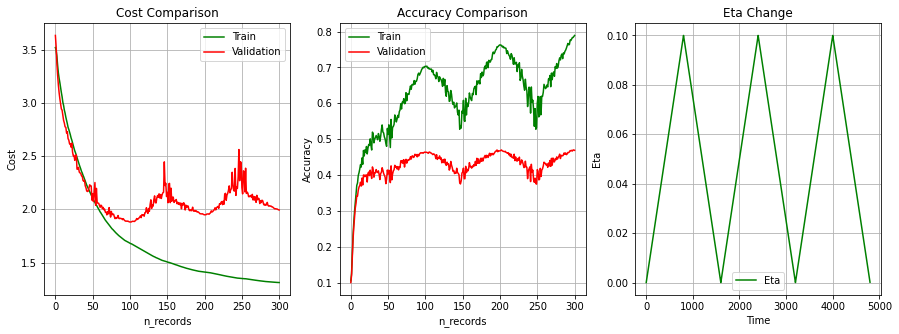

In [31]:
### Exercise - 4 _ Part1 ###
# takes around 4 minutes 45 seconds
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max, n_steps]
param_list = [network1, train_X_Norm, validation_X_Norm, 100, 3, 0.01, 100, 100, 1e-5, 1e-1, 800]
layers2, W2, b2, eta_train = Train_Cyclical(param_list, 'Batch_aggregated')

In [32]:
P_test, H_test = network1.EvaluationClassifier(layers2, test_X_Norm, W2, b2)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.4763
